In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import json

In [20]:
dataDir = ""

stockDF = pd.read_csv(dataDir+"spData.csv",usecols=["Date","Close"]).set_index("Date")
newCases = pd.read_csv(dataDir+"new_cases.csv",usecols=["date","United States"]).set_index('date')
newDeaths = pd.read_csv(dataDir+"new_deaths.csv",usecols=["date","United States"]).set_index('date')
totalCases = pd.read_csv(dataDir+"total_cases.csv",usecols=["date","United States"]).set_index('date')
totalDeaths = pd.read_csv(dataDir+"total_deaths.csv",usecols=["date","United States"]).set_index('date')


In [21]:
def incrementDateStr(dateStr, numDays):
    dateParts = [int(part) for part in dateStr.split('-')]
    date = datetime.datetime(dateParts[0], dateParts[1], dateParts[2])
    nextDay = date + datetime.timedelta(days = numDays)
    nextDayStr = str(nextDay.year) + '-' + str(nextDay.month).zfill(2) + '-' + str(nextDay.day).zfill(2)
    return nextDayStr

In [22]:
incrementDateStr("2020-02-03", 4)

'2020-02-07'

In [41]:
def prevStockMarketDay(date):
    stockDates = list(stockDF.index)
    earliestDay = stockDates[0]
    day = incrementDateStr(date, -1)
    while not day in stockDates:
        day = incrementDateStr(day, -1)
        if day < earliestDay:
            return -1
    return day

In [39]:
print(prevStockMarketDay("2020-01-06"))

2020-01-02
2020-01-03


In [42]:
import datetime

dataframe = pd.DataFrame(columns=['stockDate', 'casesDate', 'stock', 'prevDayStock', 'newCases', 'newDeaths', 'totalCases', 'totalDeaths'])
stockDates = list(stockDF.index)
newCasesDates = list(newCases.index)
newDeathsDates = list(newDeaths.index)
totalCasesDates = list(totalCases.index)
totalDeathsDates = list(totalDeaths.index)
dateLists = [newCasesDates, newDeathsDates, totalCasesDates, totalDeathsDates]
for dateStr in newCasesDates:
  dateParts = [int(part) for part in dateStr.split('-')]
  date = datetime.datetime(dateParts[0], dateParts[1], dateParts[2])
  nextDay = date + datetime.timedelta(days = 1)
  nextDayStr = str(nextDay.year) + '-' + str(nextDay.month).zfill(2) + '-' + str(nextDay.day).zfill(2)
  if all([dateStr in lists for lists in dateLists]) and nextDayStr in stockDates:
    prevStockDay = prevStockMarketDay(nextDayStr)
    if prevStockDay in stockDates:
        new_row = {'stockDate':nextDayStr, 'casesDate':dateStr, 'stock':stockDF['Close'][nextDayStr], 'prevDayStock':stockDF['Close'][prevStockDay], 'newCases':newCases['United States'][dateStr], 'newDeaths':newDeaths['United States'][dateStr],'totalCases':totalCases['United States'][dateStr], 'totalDeaths':totalDeaths['United States'][dateStr]}
        dataframe = dataframe.append(new_row, ignore_index=True)

In [26]:
dataframe.head

<bound method NDFrame.head of       stockDate   casesDate        stock  prevDayStock newCases newDeaths  \
0    2020-01-03  2020-01-02  3234.850098   3257.850098        0         0   
1    2020-01-06  2020-01-05  3246.280029   3234.850098        0         0   
2    2020-01-07  2020-01-06  3237.179932   3246.280029        0         0   
3    2020-01-08  2020-01-07  3253.050049   3237.179932        0         0   
4    2020-01-09  2020-01-08  3274.699951   3253.050049        0         0   
..          ...         ...          ...           ...      ...       ...   
174  2020-09-21  2020-09-20  3281.060059   3319.469971    40295       669   
175  2020-09-22  2020-09-21  3315.570068   3281.060059    39852       251   
176  2020-09-23  2020-09-22  3236.919922   3315.570068    53153       372   
177  2020-09-24  2020-09-23  3246.590088   3236.919922    38307       926   
178  2020-09-25  2020-09-24  3298.459961   3246.590088    37930      1102   

    totalCases totalDeaths  
0            0  

In [6]:
print(totalDeaths.index)

Index(['2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
       ...
       '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21',
       '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26'],
      dtype='object', name='date', length=271)


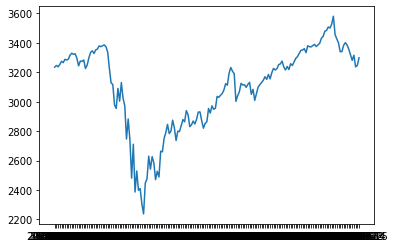

In [27]:
plt.plot(dataframe["stockDate"], dataframe["stock"])

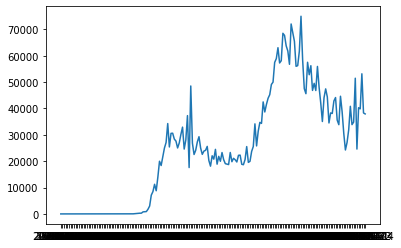

In [17]:
plt.plot(dataframe["casesDate"], dataframe["newDeaths"])

In [108]:
from sklearn.model_selection import train_test_split
X = dataframe.drop(["stock", "casesDate", "stockDate"],axis=1).values
y = dataframe['stock'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.metrics import mae

model = Sequential()

model.add(Dense(5, input_shape=[5]))
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1))

# TODO dropout, data, model

model.compile(optimizer='adam',loss='mse', metrics=[mae])

In [111]:
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=256,epochs=5000, verbose = 1)

Train on 138 samples, validate on 47 samples
Epoch 1/5000
138/138 [==============================] - 0s 2ms/sample - loss: 9637300.0000 - mean_absolute_error: 3090.4324 - val_loss: 9813473.0000 - val_mean_absolute_error: 3123.5784
Epoch 2/5000
138/138 [==============================] - 0s 51us/sample - loss: 9637176.0000 - mean_absolute_error: 3090.4121 - val_loss: 9813360.0000 - val_mean_absolute_error: 3123.5608
Epoch 3/5000
138/138 [==============================] - 0s 51us/sample - loss: 9637051.0000 - mean_absolute_error: 3090.3921 - val_loss: 9813247.0000 - val_mean_absolute_error: 3123.5425
Epoch 4/5000
138/138 [==============================] - 0s 58us/sample - loss: 9636926.0000 - mean_absolute_error: 3090.3723 - val_loss: 9813132.0000 - val_mean_absolute_error: 3123.5247
Epoch 5/5000
138/138 [==============================] - 0s 58us/sample - loss: 9636800.0000 - mean_absolute_error: 3090.3518 - val_loss: 9813015.0000 - val_mean_absolute_error: 3123.5061
Epoch 6/5000
138/138 

Epoch 45/5000
138/138 [==============================] - 0s 58us/sample - loss: 9630095.0000 - mean_absolute_error: 3089.2830 - val_loss: 9806312.0000 - val_mean_absolute_error: 3122.4468
Epoch 46/5000
138/138 [==============================] - 0s 51us/sample - loss: 9629849.0000 - mean_absolute_error: 3089.2441 - val_loss: 9806062.0000 - val_mean_absolute_error: 3122.4072
Epoch 47/5000
138/138 [==============================] - 0s 58us/sample - loss: 9629600.0000 - mean_absolute_error: 3089.2046 - val_loss: 9805805.0000 - val_mean_absolute_error: 3122.3665
Epoch 48/5000
138/138 [==============================] - 0s 58us/sample - loss: 9629344.0000 - mean_absolute_error: 3089.1641 - val_loss: 9805543.0000 - val_mean_absolute_error: 3122.3254
Epoch 49/5000
138/138 [==============================] - 0s 51us/sample - loss: 9629086.0000 - mean_absolute_error: 3089.1226 - val_loss: 9805281.0000 - val_mean_absolute_error: 3122.2842
Epoch 50/5000
138/138 [==============================] - 0s 

Epoch 89/5000
138/138 [==============================] - 0s 58us/sample - loss: 9613305.0000 - mean_absolute_error: 3086.6260 - val_loss: 9789539.0000 - val_mean_absolute_error: 3119.8008
Epoch 90/5000
138/138 [==============================] - 0s 58us/sample - loss: 9612714.0000 - mean_absolute_error: 3086.5327 - val_loss: 9788958.0000 - val_mean_absolute_error: 3119.7095
Epoch 91/5000
138/138 [==============================] - 0s 51us/sample - loss: 9612112.0000 - mean_absolute_error: 3086.4377 - val_loss: 9788366.0000 - val_mean_absolute_error: 3119.6157
Epoch 92/5000
138/138 [==============================] - 0s 58us/sample - loss: 9611496.0000 - mean_absolute_error: 3086.3403 - val_loss: 9787760.0000 - val_mean_absolute_error: 3119.5203
Epoch 93/5000
138/138 [==============================] - 0s 58us/sample - loss: 9610867.0000 - mean_absolute_error: 3086.2410 - val_loss: 9787141.0000 - val_mean_absolute_error: 3119.4229
Epoch 94/5000
138/138 [==============================] - 0s 

Epoch 133/5000
138/138 [==============================] - 0s 58us/sample - loss: 9570371.0000 - mean_absolute_error: 3079.8333 - val_loss: 9747062.0000 - val_mean_absolute_error: 3113.0913
Epoch 134/5000
138/138 [==============================] - 0s 58us/sample - loss: 9568864.0000 - mean_absolute_error: 3079.5947 - val_loss: 9745575.0000 - val_mean_absolute_error: 3112.8560
Epoch 135/5000
138/138 [==============================] - 0s 58us/sample - loss: 9567331.0000 - mean_absolute_error: 3079.3516 - val_loss: 9744061.0000 - val_mean_absolute_error: 3112.6165
Epoch 136/5000
138/138 [==============================] - 0s 65us/sample - loss: 9565771.0000 - mean_absolute_error: 3079.1040 - val_loss: 9742518.0000 - val_mean_absolute_error: 3112.3716
Epoch 137/5000
138/138 [==============================] - 0s 51us/sample - loss: 9564182.0000 - mean_absolute_error: 3078.8518 - val_loss: 9740947.0000 - val_mean_absolute_error: 3112.1230
Epoch 138/5000
138/138 [==============================]

Epoch 177/5000
138/138 [==============================] - 0s 51us/sample - loss: 9471621.0000 - mean_absolute_error: 3064.1233 - val_loss: 9649930.0000 - val_mean_absolute_error: 3097.6602
Epoch 178/5000
138/138 [==============================] - 0s 58us/sample - loss: 9468425.0000 - mean_absolute_error: 3063.6130 - val_loss: 9646784.0000 - val_mean_absolute_error: 3097.1587
Epoch 179/5000
138/138 [==============================] - 0s 65us/sample - loss: 9465176.0000 - mean_absolute_error: 3063.0942 - val_loss: 9643588.0000 - val_mean_absolute_error: 3096.6487
Epoch 180/5000
138/138 [==============================] - 0s 58us/sample - loss: 9461874.0000 - mean_absolute_error: 3062.5669 - val_loss: 9640338.0000 - val_mean_absolute_error: 3096.1304
Epoch 181/5000
138/138 [==============================] - 0s 58us/sample - loss: 9458515.0000 - mean_absolute_error: 3062.0300 - val_loss: 9637037.0000 - val_mean_absolute_error: 3095.6030
Epoch 182/5000
138/138 [==============================]

Epoch 221/5000
138/138 [==============================] - 0s 58us/sample - loss: 9268731.0000 - mean_absolute_error: 3031.5229 - val_loss: 9450632.0000 - val_mean_absolute_error: 3065.6606
Epoch 222/5000
138/138 [==============================] - 0s 58us/sample - loss: 9262361.0000 - mean_absolute_error: 3030.4917 - val_loss: 9444399.0000 - val_mean_absolute_error: 3064.6523
Epoch 223/5000
138/138 [==============================] - 0s 58us/sample - loss: 9255898.0000 - mean_absolute_error: 3029.4448 - val_loss: 9438075.0000 - val_mean_absolute_error: 3063.6284
Epoch 224/5000
138/138 [==============================] - 0s 58us/sample - loss: 9249341.0000 - mean_absolute_error: 3028.3826 - val_loss: 9431664.0000 - val_mean_absolute_error: 3062.5901
Epoch 225/5000
138/138 [==============================] - 0s 58us/sample - loss: 9242691.0000 - mean_absolute_error: 3027.3047 - val_loss: 9425164.0000 - val_mean_absolute_error: 3061.5369
Epoch 226/5000
138/138 [==============================]

Epoch 265/5000
138/138 [==============================] - 0s 58us/sample - loss: 8891518.0000 - mean_absolute_error: 2969.6089 - val_loss: 9083056.0000 - val_mean_absolute_error: 3005.3794
Epoch 266/5000
138/138 [==============================] - 0s 65us/sample - loss: 8880312.0000 - mean_absolute_error: 2967.7439 - val_loss: 9072163.0000 - val_mean_absolute_error: 3003.5681
Epoch 267/5000
138/138 [==============================] - 0s 58us/sample - loss: 8868979.0000 - mean_absolute_error: 2965.8557 - val_loss: 9061149.0000 - val_mean_absolute_error: 3001.7351
Epoch 268/5000
138/138 [==============================] - 0s 58us/sample - loss: 8857518.0000 - mean_absolute_error: 2963.9451 - val_loss: 9050013.0000 - val_mean_absolute_error: 2999.8804
Epoch 269/5000
138/138 [==============================] - 0s 58us/sample - loss: 8845929.0000 - mean_absolute_error: 2962.0112 - val_loss: 9038758.0000 - val_mean_absolute_error: 2998.0039
Epoch 270/5000
138/138 [==============================]

Epoch 309/5000
138/138 [==============================] - 0s 58us/sample - loss: 8272194.0000 - mean_absolute_error: 2864.0659 - val_loss: 8483457.0000 - val_mean_absolute_error: 2903.3352
Epoch 310/5000
138/138 [==============================] - 0s 65us/sample - loss: 8254997.5000 - mean_absolute_error: 2861.0601 - val_loss: 8466841.0000 - val_mean_absolute_error: 2900.4358
Epoch 311/5000
138/138 [==============================] - 0s 58us/sample - loss: 8237659.0000 - mean_absolute_error: 2858.0249 - val_loss: 8450083.0000 - val_mean_absolute_error: 2897.5081
Epoch 312/5000
138/138 [==============================] - 0s 58us/sample - loss: 8220176.5000 - mean_absolute_error: 2854.9604 - val_loss: 8433188.0000 - val_mean_absolute_error: 2894.5518
Epoch 313/5000
138/138 [==============================] - 0s 58us/sample - loss: 8202551.5000 - mean_absolute_error: 2851.8660 - val_loss: 8416157.0000 - val_mean_absolute_error: 2891.5671
Epoch 314/5000
138/138 [==============================]

Epoch 353/5000
138/138 [==============================] - 0s 58us/sample - loss: 7382015.5000 - mean_absolute_error: 2702.3413 - val_loss: 7623514.5000 - val_mean_absolute_error: 2747.5393
Epoch 354/5000
138/138 [==============================] - 0s 65us/sample - loss: 7358718.5000 - mean_absolute_error: 2697.9265 - val_loss: 7601015.0000 - val_mean_absolute_error: 2743.2925
Epoch 355/5000
138/138 [==============================] - 0s 58us/sample - loss: 7335295.0000 - mean_absolute_error: 2693.4773 - val_loss: 7578392.5000 - val_mean_absolute_error: 2739.0129
Epoch 356/5000
138/138 [==============================] - 0s 58us/sample - loss: 7311744.0000 - mean_absolute_error: 2688.9941 - val_loss: 7555646.5000 - val_mean_absolute_error: 2734.7004
Epoch 357/5000
138/138 [==============================] - 0s 58us/sample - loss: 7288069.5000 - mean_absolute_error: 2684.4761 - val_loss: 7532778.0000 - val_mean_absolute_error: 2730.3550
Epoch 358/5000
138/138 [==============================]

Epoch 397/5000
138/138 [==============================] - 0s 51us/sample - loss: 6252315.0000 - mean_absolute_error: 2475.1121 - val_loss: 6531259.0000 - val_mean_absolute_error: 2529.1423
Epoch 398/5000
138/138 [==============================] - 0s 58us/sample - loss: 6224633.5000 - mean_absolute_error: 2469.1616 - val_loss: 6504440.0000 - val_mean_absolute_error: 2523.4253
Epoch 399/5000
138/138 [==============================] - 0s 58us/sample - loss: 6196889.5000 - mean_absolute_error: 2463.1768 - val_loss: 6477556.5000 - val_mean_absolute_error: 2517.6758
Epoch 400/5000
138/138 [==============================] - 0s 58us/sample - loss: 6169085.0000 - mean_absolute_error: 2457.1577 - val_loss: 6450610.5000 - val_mean_absolute_error: 2511.8926
Epoch 401/5000
138/138 [==============================] - 0s 58us/sample - loss: 6141224.0000 - mean_absolute_error: 2451.1047 - val_loss: 6423606.5000 - val_mean_absolute_error: 2506.0771
Epoch 402/5000
138/138 [==============================]

Epoch 441/5000
138/138 [==============================] - 0s 58us/sample - loss: 5005991.0000 - mean_absolute_error: 2182.6392 - val_loss: 5319232.5000 - val_mean_absolute_error: 2248.1118
Epoch 442/5000
138/138 [==============================] - 0s 58us/sample - loss: 4977808.5000 - mean_absolute_error: 2175.3274 - val_loss: 5291685.0000 - val_mean_absolute_error: 2241.0825
Epoch 443/5000
138/138 [==============================] - 0s 51us/sample - loss: 4949672.0000 - mean_absolute_error: 2167.9897 - val_loss: 5264176.0000 - val_mean_absolute_error: 2234.0283
Epoch 444/5000
138/138 [==============================] - 0s 58us/sample - loss: 4921585.5000 - mean_absolute_error: 2160.6272 - val_loss: 5236706.5000 - val_mean_absolute_error: 2226.9500
Epoch 445/5000
138/138 [==============================] - 0s 65us/sample - loss: 4893551.0000 - mean_absolute_error: 2153.2397 - val_loss: 5209280.0000 - val_mean_absolute_error: 2219.8472
Epoch 446/5000
138/138 [==============================]

Epoch 485/5000
138/138 [==============================] - 0s 58us/sample - loss: 3844575.2500 - mean_absolute_error: 1842.1068 - val_loss: 4175808.2500 - val_mean_absolute_error: 1920.3768
Epoch 486/5000
138/138 [==============================] - 0s 58us/sample - loss: 3820846.7500 - mean_absolute_error: 1834.0773 - val_loss: 4152226.7500 - val_mean_absolute_error: 1912.6376
Epoch 487/5000
138/138 [==============================] - 0s 58us/sample - loss: 3797270.7500 - mean_absolute_error: 1826.0431 - val_loss: 4128783.7500 - val_mean_absolute_error: 1904.8933
Epoch 488/5000
138/138 [==============================] - 0s 58us/sample - loss: 3773848.2500 - mean_absolute_error: 1818.0055 - val_loss: 4105482.2500 - val_mean_absolute_error: 1897.1444
Epoch 489/5000
138/138 [==============================] - 0s 58us/sample - loss: 3750581.5000 - mean_absolute_error: 1809.9648 - val_loss: 4082321.7500 - val_mean_absolute_error: 1889.3916
Epoch 490/5000
138/138 [==============================]

Epoch 529/5000
138/138 [==============================] - 0s 51us/sample - loss: 2960191.2500 - mean_absolute_error: 1497.1614 - val_loss: 3286327.2500 - val_mean_absolute_error: 1603.4861
Epoch 530/5000
138/138 [==============================] - 0s 58us/sample - loss: 2944078.0000 - mean_absolute_error: 1490.3733 - val_loss: 3269880.7500 - val_mean_absolute_error: 1596.8195
Epoch 531/5000
138/138 [==============================] - 0s 58us/sample - loss: 2928142.5000 - mean_absolute_error: 1483.6061 - val_loss: 3253605.5000 - val_mean_absolute_error: 1590.1709
Epoch 532/5000
138/138 [==============================] - 0s 58us/sample - loss: 2912385.5000 - mean_absolute_error: 1476.8601 - val_loss: 3237495.7500 - val_mean_absolute_error: 1583.7234
Epoch 533/5000
138/138 [==============================] - 0s 58us/sample - loss: 2896806.2500 - mean_absolute_error: 1470.1355 - val_loss: 3221543.2500 - val_mean_absolute_error: 1577.5613
Epoch 534/5000
138/138 [==============================]

Epoch 573/5000
138/138 [==============================] - 0s 58us/sample - loss: 2404644.2500 - mean_absolute_error: 1296.7793 - val_loss: 2710229.7500 - val_mean_absolute_error: 1402.5597
Epoch 574/5000
138/138 [==============================] - 0s 58us/sample - loss: 2395237.2500 - mean_absolute_error: 1294.3125 - val_loss: 2700296.2500 - val_mean_absolute_error: 1399.4574
Epoch 575/5000
138/138 [==============================] - 0s 58us/sample - loss: 2385950.7500 - mean_absolute_error: 1291.8796 - val_loss: 2690483.5000 - val_mean_absolute_error: 1396.6218
Epoch 576/5000
138/138 [==============================] - 0s 58us/sample - loss: 2376783.2500 - mean_absolute_error: 1289.5519 - val_loss: 2680793.2500 - val_mean_absolute_error: 1393.7942
Epoch 577/5000
138/138 [==============================] - 0s 58us/sample - loss: 2367735.5000 - mean_absolute_error: 1287.2303 - val_loss: 2671224.5000 - val_mean_absolute_error: 1390.9742
Epoch 578/5000
138/138 [==============================]

Epoch 617/5000
138/138 [==============================] - 0s 50us/sample - loss: 2080536.1250 - mean_absolute_error: 1207.6335 - val_loss: 2371035.2500 - val_mean_absolute_error: 1294.2161
Epoch 618/5000
138/138 [==============================] - 0s 58us/sample - loss: 2074879.1250 - mean_absolute_error: 1205.9397 - val_loss: 2365243.5000 - val_mean_absolute_error: 1292.0314
Epoch 619/5000
138/138 [==============================] - 0s 58us/sample - loss: 2069287.8750 - mean_absolute_error: 1204.2509 - val_loss: 2359521.7500 - val_mean_absolute_error: 1289.8556
Epoch 620/5000
138/138 [==============================] - 0s 58us/sample - loss: 2063761.1250 - mean_absolute_error: 1202.5673 - val_loss: 2353869.2500 - val_mean_absolute_error: 1287.6892
Epoch 621/5000
138/138 [==============================] - 0s 58us/sample - loss: 2058298.2500 - mean_absolute_error: 1200.8887 - val_loss: 2348285.2500 - val_mean_absolute_error: 1285.5321
Epoch 622/5000
138/138 [==============================]

Epoch 661/5000
138/138 [==============================] - 0s 51us/sample - loss: 1878143.2500 - mean_absolute_error: 1142.6105 - val_loss: 2170323.2500 - val_mean_absolute_error: 1209.7396
Epoch 662/5000
138/138 [==============================] - 0s 58us/sample - loss: 1874390.6250 - mean_absolute_error: 1141.3871 - val_loss: 2166772.0000 - val_mean_absolute_error: 1208.0343
Epoch 663/5000
138/138 [==============================] - 0s 58us/sample - loss: 1870659.5000 - mean_absolute_error: 1140.1643 - val_loss: 2163255.7500 - val_mean_absolute_error: 1206.3363
Epoch 664/5000
138/138 [==============================] - 0s 58us/sample - loss: 1866949.3750 - mean_absolute_error: 1138.9418 - val_loss: 2159772.5000 - val_mean_absolute_error: 1204.6456
Epoch 665/5000
138/138 [==============================] - 0s 58us/sample - loss: 1863263.5000 - mean_absolute_error: 1137.7200 - val_loss: 2156310.2500 - val_mean_absolute_error: 1202.9609
Epoch 666/5000
138/138 [==============================]

Epoch 705/5000
138/138 [==============================] - 0s 58us/sample - loss: 1732076.3750 - mean_absolute_error: 1091.5177 - val_loss: 2036527.3750 - val_mean_absolute_error: 1141.7551
Epoch 706/5000
138/138 [==============================] - 0s 58us/sample - loss: 1729067.2500 - mean_absolute_error: 1090.4070 - val_loss: 2033847.3750 - val_mean_absolute_error: 1140.4098
Epoch 707/5000
138/138 [==============================] - 0s 58us/sample - loss: 1726073.2500 - mean_absolute_error: 1089.2988 - val_loss: 2031152.3750 - val_mean_absolute_error: 1139.0642
Epoch 708/5000
138/138 [==============================] - 0s 65us/sample - loss: 1723096.0000 - mean_absolute_error: 1088.1935 - val_loss: 2028470.1250 - val_mean_absolute_error: 1137.7238
Epoch 709/5000
138/138 [==============================] - 0s 65us/sample - loss: 1720135.3750 - mean_absolute_error: 1087.0911 - val_loss: 2025803.8750 - val_mean_absolute_error: 1136.3893
Epoch 710/5000
138/138 [==============================]

Epoch 749/5000
138/138 [==============================] - 0s 58us/sample - loss: 1613698.7500 - mean_absolute_error: 1045.3630 - val_loss: 1925536.3750 - val_mean_absolute_error: 1086.3962
Epoch 750/5000
138/138 [==============================] - 0s 51us/sample - loss: 1611264.6250 - mean_absolute_error: 1044.3693 - val_loss: 1923089.7500 - val_mean_absolute_error: 1085.2114
Epoch 751/5000
138/138 [==============================] - 0s 51us/sample - loss: 1608841.8750 - mean_absolute_error: 1043.3781 - val_loss: 1920652.8750 - val_mean_absolute_error: 1084.0309
Epoch 752/5000
138/138 [==============================] - 0s 58us/sample - loss: 1606430.7500 - mean_absolute_error: 1042.3894 - val_loss: 1918226.3750 - val_mean_absolute_error: 1082.8542
Epoch 753/5000
138/138 [==============================] - 0s 51us/sample - loss: 1604031.2500 - mean_absolute_error: 1041.4036 - val_loss: 1915810.7500 - val_mean_absolute_error: 1081.6827
Epoch 754/5000
138/138 [==============================]

Epoch 793/5000
138/138 [==============================] - 0s 51us/sample - loss: 1515019.1250 - mean_absolute_error: 1004.1038 - val_loss: 1826089.5000 - val_mean_absolute_error: 1038.1184
Epoch 794/5000
138/138 [==============================] - 0s 58us/sample - loss: 1513000.0000 - mean_absolute_error: 1003.2333 - val_loss: 1823971.7500 - val_mean_absolute_error: 1037.1042
Epoch 795/5000
138/138 [==============================] - 0s 51us/sample - loss: 1510991.2500 - mean_absolute_error: 1002.3657 - val_loss: 1821862.1250 - val_mean_absolute_error: 1036.0944
Epoch 796/5000
138/138 [==============================] - 0s 51us/sample - loss: 1508992.5000 - mean_absolute_error: 1001.5009 - val_loss: 1819761.0000 - val_mean_absolute_error: 1035.0887
Epoch 797/5000
138/138 [==============================] - 0s 51us/sample - loss: 1507003.7500 - mean_absolute_error: 1000.6390 - val_loss: 1817668.1250 - val_mean_absolute_error: 1034.0868
Epoch 798/5000
138/138 [==============================]

Epoch 837/5000
138/138 [==============================] - 0s 51us/sample - loss: 1431131.5000 - mean_absolute_error: 967.1823 - val_loss: 1729809.7500 - val_mean_absolute_error: 995.6644
Epoch 838/5000
138/138 [==============================] - 0s 51us/sample - loss: 1429280.5000 - mean_absolute_error: 966.3562 - val_loss: 1727484.6250 - val_mean_absolute_error: 994.7249
Epoch 839/5000
138/138 [==============================] - 0s 51us/sample - loss: 1427435.8750 - mean_absolute_error: 965.5317 - val_loss: 1725164.2500 - val_mean_absolute_error: 993.7875
Epoch 840/5000
138/138 [==============================] - 0s 58us/sample - loss: 1425597.7500 - mean_absolute_error: 964.7090 - val_loss: 1722848.3750 - val_mean_absolute_error: 992.8525
Epoch 841/5000
138/138 [==============================] - 0s 51us/sample - loss: 1423766.0000 - mean_absolute_error: 963.8880 - val_loss: 1720537.8750 - val_mean_absolute_error: 991.9200
Epoch 842/5000
138/138 [==============================] - 0s 51us

Epoch 881/5000
138/138 [==============================] - 0s 58us/sample - loss: 1354868.5000 - mean_absolute_error: 932.8903 - val_loss: 1632257.5000 - val_mean_absolute_error: 957.4025
Epoch 882/5000
138/138 [==============================] - 0s 58us/sample - loss: 1353255.6250 - mean_absolute_error: 932.1574 - val_loss: 1630153.5000 - val_mean_absolute_error: 956.6195
Epoch 883/5000
138/138 [==============================] - 0s 51us/sample - loss: 1351649.0000 - mean_absolute_error: 931.4265 - val_loss: 1628054.7500 - val_mean_absolute_error: 955.8383
Epoch 884/5000
138/138 [==============================] - 0s 58us/sample - loss: 1350048.2500 - mean_absolute_error: 930.6970 - val_loss: 1625961.5000 - val_mean_absolute_error: 955.0588
Epoch 885/5000
138/138 [==============================] - 0s 58us/sample - loss: 1348442.3750 - mean_absolute_error: 929.9668 - val_loss: 1623871.5000 - val_mean_absolute_error: 954.2808
Epoch 886/5000
138/138 [==============================] - 0s 58us

Epoch 925/5000
138/138 [==============================] - 0s 58us/sample - loss: 1287355.8750 - mean_absolute_error: 902.2592 - val_loss: 1543601.5000 - val_mean_absolute_error: 924.3254
Epoch 926/5000
138/138 [==============================] - 0s 51us/sample - loss: 1285889.7500 - mean_absolute_error: 901.6650 - val_loss: 1541664.1250 - val_mean_absolute_error: 923.6017
Epoch 927/5000
138/138 [==============================] - 0s 58us/sample - loss: 1284428.0000 - mean_absolute_error: 901.0714 - val_loss: 1539731.1250 - val_mean_absolute_error: 922.8795
Epoch 928/5000
138/138 [==============================] - 0s 65us/sample - loss: 1282971.0000 - mean_absolute_error: 900.4786 - val_loss: 1537801.7500 - val_mean_absolute_error: 922.1584
Epoch 929/5000
138/138 [==============================] - 0s 80us/sample - loss: 1281518.8750 - mean_absolute_error: 899.8865 - val_loss: 1535876.3750 - val_mean_absolute_error: 921.4385
Epoch 930/5000
138/138 [==============================] - 0s 80us

Epoch 969/5000
138/138 [==============================] - 0s 51us/sample - loss: 1226451.2500 - mean_absolute_error: 876.6944 - val_loss: 1461933.6250 - val_mean_absolute_error: 893.5383
Epoch 970/5000
138/138 [==============================] - 0s 51us/sample - loss: 1225144.7500 - mean_absolute_error: 876.1271 - val_loss: 1460156.6250 - val_mean_absolute_error: 892.8601
Epoch 971/5000
138/138 [==============================] - 0s 58us/sample - loss: 1223838.6250 - mean_absolute_error: 875.5599 - val_loss: 1458381.6250 - val_mean_absolute_error: 892.1824
Epoch 972/5000
138/138 [==============================] - 0s 58us/sample - loss: 1222530.0000 - mean_absolute_error: 874.9918 - val_loss: 1456608.1250 - val_mean_absolute_error: 891.5053
Epoch 973/5000
138/138 [==============================] - 0s 51us/sample - loss: 1221217.1250 - mean_absolute_error: 874.4225 - val_loss: 1454836.3750 - val_mean_absolute_error: 890.8290
Epoch 974/5000
138/138 [==============================] - 0s 58us

Epoch 1013/5000
138/138 [==============================] - 0s 58us/sample - loss: 1170198.8750 - mean_absolute_error: 852.2022 - val_loss: 1385774.8750 - val_mean_absolute_error: 864.3544
Epoch 1014/5000
138/138 [==============================] - 0s 58us/sample - loss: 1168966.8750 - mean_absolute_error: 851.6678 - val_loss: 1384095.8750 - val_mean_absolute_error: 863.7131
Epoch 1015/5000
138/138 [==============================] - 0s 51us/sample - loss: 1167738.2500 - mean_absolute_error: 851.1340 - val_loss: 1382419.8750 - val_mean_absolute_error: 863.0724
Epoch 1016/5000
138/138 [==============================] - 0s 51us/sample - loss: 1166507.7500 - mean_absolute_error: 850.5999 - val_loss: 1380745.7500 - val_mean_absolute_error: 862.4322
Epoch 1017/5000
138/138 [==============================] - 0s 58us/sample - loss: 1165272.2500 - mean_absolute_error: 850.0645 - val_loss: 1379071.8750 - val_mean_absolute_error: 861.7922
Epoch 1018/5000
138/138 [==============================] - 0

Epoch 1057/5000
138/138 [==============================] - 0s 58us/sample - loss: 1116420.7500 - mean_absolute_error: 828.7053 - val_loss: 1313293.1250 - val_mean_absolute_error: 836.3585
Epoch 1058/5000
138/138 [==============================] - 0s 51us/sample - loss: 1115223.2500 - mean_absolute_error: 828.1724 - val_loss: 1311678.5000 - val_mean_absolute_error: 835.7250
Epoch 1059/5000
138/138 [==============================] - 0s 51us/sample - loss: 1114028.7500 - mean_absolute_error: 827.6398 - val_loss: 1310066.7500 - val_mean_absolute_error: 835.0921
Epoch 1060/5000
138/138 [==============================] - 0s 51us/sample - loss: 1112837.3750 - mean_absolute_error: 827.1080 - val_loss: 1308457.7500 - val_mean_absolute_error: 834.4595
Epoch 1061/5000
138/138 [==============================] - 0s 51us/sample - loss: 1111649.0000 - mean_absolute_error: 826.5763 - val_loss: 1306851.6250 - val_mean_absolute_error: 833.8275
Epoch 1062/5000
138/138 [==============================] - 0

Epoch 1101/5000
138/138 [==============================] - 0s 51us/sample - loss: 1065542.6250 - mean_absolute_error: 805.5032 - val_loss: 1244500.3750 - val_mean_absolute_error: 811.1298
Epoch 1102/5000
138/138 [==============================] - 0s 51us/sample - loss: 1064380.6250 - mean_absolute_error: 804.9661 - val_loss: 1242962.6250 - val_mean_absolute_error: 810.5959
Epoch 1103/5000
138/138 [==============================] - 0s 51us/sample - loss: 1063212.8750 - mean_absolute_error: 804.4271 - val_loss: 1241424.6250 - val_mean_absolute_error: 810.0621
Epoch 1104/5000
138/138 [==============================] - 0s 51us/sample - loss: 1062045.7500 - mean_absolute_error: 803.8876 - val_loss: 1239886.7500 - val_mean_absolute_error: 809.5283
Epoch 1105/5000
138/138 [==============================] - 0s 51us/sample - loss: 1060879.2500 - mean_absolute_error: 803.3478 - val_loss: 1238349.1250 - val_mean_absolute_error: 808.9943
Epoch 1106/5000
138/138 [==============================] - 0

Epoch 1145/5000
138/138 [==============================] - 0s 51us/sample - loss: 1012867.9375 - mean_absolute_error: 780.9858 - val_loss: 1176656.8750 - val_mean_absolute_error: 787.2317
Epoch 1146/5000
138/138 [==============================] - 0s 58us/sample - loss: 1011696.6875 - mean_absolute_error: 780.4269 - val_loss: 1175145.2500 - val_mean_absolute_error: 786.6831
Epoch 1147/5000
138/138 [==============================] - 0s 51us/sample - loss: 1010528.5625 - mean_absolute_error: 779.8682 - val_loss: 1173637.0000 - val_mean_absolute_error: 786.1351
Epoch 1148/5000
138/138 [==============================] - 0s 51us/sample - loss: 1009363.8125 - mean_absolute_error: 779.3099 - val_loss: 1172132.1250 - val_mean_absolute_error: 785.5875
Epoch 1149/5000
138/138 [==============================] - 0s 51us/sample - loss: 1008202.6875 - mean_absolute_error: 778.7520 - val_loss: 1170630.5000 - val_mean_absolute_error: 785.0406
Epoch 1150/5000
138/138 [==============================] - 0

Epoch 1189/5000
138/138 [==============================] - 0s 51us/sample - loss: 964285.1875 - mean_absolute_error: 757.5356 - val_loss: 1113244.2500 - val_mean_absolute_error: 763.5512
Epoch 1190/5000
138/138 [==============================] - 0s 43us/sample - loss: 963244.5000 - mean_absolute_error: 757.0168 - val_loss: 1111871.1250 - val_mean_absolute_error: 763.0203
Epoch 1191/5000
138/138 [==============================] - 0s 51us/sample - loss: 962206.3125 - mean_absolute_error: 756.4987 - val_loss: 1110500.3750 - val_mean_absolute_error: 762.4897
Epoch 1192/5000
138/138 [==============================] - 0s 51us/sample - loss: 961170.5625 - mean_absolute_error: 755.9810 - val_loss: 1109132.3750 - val_mean_absolute_error: 761.9593
Epoch 1193/5000
138/138 [==============================] - 0s 58us/sample - loss: 960137.3750 - mean_absolute_error: 755.4641 - val_loss: 1107766.7500 - val_mean_absolute_error: 761.4291
Epoch 1194/5000
138/138 [==============================] - 0s 51u

Epoch 1233/5000
138/138 [==============================] - 0s 51us/sample - loss: 920522.3125 - mean_absolute_error: 735.2256 - val_loss: 1054987.1250 - val_mean_absolute_error: 740.4411
Epoch 1234/5000
138/138 [==============================] - 0s 57us/sample - loss: 919565.5000 - mean_absolute_error: 734.7290 - val_loss: 1053707.3750 - val_mean_absolute_error: 739.9227
Epoch 1235/5000
138/138 [==============================] - 0s 51us/sample - loss: 918610.2500 - mean_absolute_error: 734.2328 - val_loss: 1052429.7500 - val_mean_absolute_error: 739.4048
Epoch 1236/5000
138/138 [==============================] - 0s 51us/sample - loss: 917656.6875 - mean_absolute_error: 733.7372 - val_loss: 1051153.6250 - val_mean_absolute_error: 738.8871
Epoch 1237/5000
138/138 [==============================] - 0s 51us/sample - loss: 916704.4375 - mean_absolute_error: 733.2421 - val_loss: 1049879.6250 - val_mean_absolute_error: 738.3700
Epoch 1238/5000
138/138 [==============================] - 0s 58u

Epoch 1277/5000
138/138 [==============================] - 0s 51us/sample - loss: 878189.9375 - mean_absolute_error: 713.6298 - val_loss: 999265.8750 - val_mean_absolute_error: 717.7008
Epoch 1278/5000
138/138 [==============================] - 0s 51us/sample - loss: 877228.8750 - mean_absolute_error: 713.1571 - val_loss: 998012.5000 - val_mean_absolute_error: 717.1829
Epoch 1279/5000
138/138 [==============================] - 0s 51us/sample - loss: 876262.7500 - mean_absolute_error: 712.6827 - val_loss: 996759.5000 - val_mean_absolute_error: 716.6650
Epoch 1280/5000
138/138 [==============================] - 0s 51us/sample - loss: 875297.1875 - mean_absolute_error: 712.2082 - val_loss: 995506.6250 - val_mean_absolute_error: 716.1470
Epoch 1281/5000
138/138 [==============================] - 0s 58us/sample - loss: 874332.1250 - mean_absolute_error: 711.7336 - val_loss: 994254.1250 - val_mean_absolute_error: 715.6290
Epoch 1282/5000
138/138 [==============================] - 0s 51us/sam

138/138 [==============================] - 0s 51us/sample - loss: 835968.8750 - mean_absolute_error: 692.5963 - val_loss: 944757.6250 - val_mean_absolute_error: 696.1007
Epoch 1322/5000
138/138 [==============================] - 0s 51us/sample - loss: 835013.0000 - mean_absolute_error: 692.1167 - val_loss: 943539.7500 - val_mean_absolute_error: 695.6306
Epoch 1323/5000
138/138 [==============================] - 0s 51us/sample - loss: 834057.8750 - mean_absolute_error: 691.6370 - val_loss: 942322.5625 - val_mean_absolute_error: 695.1599
Epoch 1324/5000
138/138 [==============================] - 0s 51us/sample - loss: 833103.6250 - mean_absolute_error: 691.1572 - val_loss: 941106.3750 - val_mean_absolute_error: 694.6892
Epoch 1325/5000
138/138 [==============================] - 0s 51us/sample - loss: 832150.5000 - mean_absolute_error: 690.6776 - val_loss: 939891.2500 - val_mean_absolute_error: 694.2186
Epoch 1326/5000
138/138 [==============================] - 0s 51us/sample - loss: 8311

Epoch 1366/5000
138/138 [==============================] - 0s 58us/sample - loss: 793598.8125 - mean_absolute_error: 671.1459 - val_loss: 890912.9375 - val_mean_absolute_error: 674.7470
Epoch 1367/5000
138/138 [==============================] - 0s 51us/sample - loss: 792671.6250 - mean_absolute_error: 670.6902 - val_loss: 889737.5625 - val_mean_absolute_error: 674.2676
Epoch 1368/5000
138/138 [==============================] - 0s 51us/sample - loss: 791745.2500 - mean_absolute_error: 670.2346 - val_loss: 888563.1250 - val_mean_absolute_error: 673.7880
Epoch 1369/5000
138/138 [==============================] - 0s 58us/sample - loss: 790816.0000 - mean_absolute_error: 669.7780 - val_loss: 887389.4375 - val_mean_absolute_error: 673.3083
Epoch 1370/5000
138/138 [==============================] - 0s 51us/sample - loss: 789886.9375 - mean_absolute_error: 669.3214 - val_loss: 886216.0625 - val_mean_absolute_error: 672.8286
Epoch 1371/5000
138/138 [==============================] - 0s 51us/sam

Epoch 1411/5000
138/138 [==============================] - 0s 51us/sample - loss: 751449.0625 - mean_absolute_error: 650.3489 - val_loss: 838300.1875 - val_mean_absolute_error: 653.9730
Epoch 1412/5000
138/138 [==============================] - 0s 51us/sample - loss: 750512.5625 - mean_absolute_error: 649.8821 - val_loss: 837138.8750 - val_mean_absolute_error: 653.5188
Epoch 1413/5000
138/138 [==============================] - 0s 58us/sample - loss: 749576.3750 - mean_absolute_error: 649.4152 - val_loss: 835978.3125 - val_mean_absolute_error: 653.0645
Epoch 1414/5000
138/138 [==============================] - 0s 58us/sample - loss: 748640.7500 - mean_absolute_error: 648.9481 - val_loss: 834818.1875 - val_mean_absolute_error: 652.6097
Epoch 1415/5000
138/138 [==============================] - 0s 51us/sample - loss: 747705.5625 - mean_absolute_error: 648.4813 - val_loss: 833658.7500 - val_mean_absolute_error: 652.1544
Epoch 1416/5000
138/138 [==============================] - 0s 58us/sam

138/138 [==============================] - 0s 51us/sample - loss: 710586.6250 - mean_absolute_error: 630.5087 - val_loss: 787743.0000 - val_mean_absolute_error: 633.9648
Epoch 1456/5000
138/138 [==============================] - 0s 58us/sample - loss: 709658.0000 - mean_absolute_error: 630.0554 - val_loss: 786602.3750 - val_mean_absolute_error: 633.5316
Epoch 1457/5000
138/138 [==============================] - 0s 51us/sample - loss: 708729.2500 - mean_absolute_error: 629.6017 - val_loss: 785461.9375 - val_mean_absolute_error: 633.0977
Epoch 1458/5000
138/138 [==============================] - 0s 51us/sample - loss: 707800.4375 - mean_absolute_error: 629.1477 - val_loss: 784321.6250 - val_mean_absolute_error: 632.6634
Epoch 1459/5000
138/138 [==============================] - 0s 51us/sample - loss: 706871.6250 - mean_absolute_error: 628.6934 - val_loss: 783181.6250 - val_mean_absolute_error: 632.2289
Epoch 1460/5000
138/138 [==============================] - 0s 51us/sample - loss: 7059

Epoch 1500/5000
138/138 [==============================] - 0s 51us/sample - loss: 668043.3750 - mean_absolute_error: 609.5836 - val_loss: 736184.3125 - val_mean_absolute_error: 613.9531
Epoch 1501/5000
138/138 [==============================] - 0s 51us/sample - loss: 667086.1875 - mean_absolute_error: 609.1075 - val_loss: 735033.1875 - val_mean_absolute_error: 613.4938
Epoch 1502/5000
138/138 [==============================] - 0s 58us/sample - loss: 666128.5625 - mean_absolute_error: 608.6310 - val_loss: 733882.1250 - val_mean_absolute_error: 613.0340
Epoch 1503/5000
138/138 [==============================] - 0s 58us/sample - loss: 665170.7500 - mean_absolute_error: 608.1542 - val_loss: 732730.6250 - val_mean_absolute_error: 612.5732
Epoch 1504/5000
138/138 [==============================] - 0s 58us/sample - loss: 664212.6250 - mean_absolute_error: 607.6768 - val_loss: 731579.1250 - val_mean_absolute_error: 612.1115
Epoch 1505/5000
138/138 [==============================] - 0s 58us/sam

Epoch 1545/5000
138/138 [==============================] - 0s 51us/sample - loss: 624365.1250 - mean_absolute_error: 587.7341 - val_loss: 683875.6250 - val_mean_absolute_error: 592.5330
Epoch 1546/5000
138/138 [==============================] - 0s 51us/sample - loss: 623381.5000 - mean_absolute_error: 587.2355 - val_loss: 682699.1250 - val_mean_absolute_error: 592.0430
Epoch 1547/5000
138/138 [==============================] - 0s 51us/sample - loss: 622394.4375 - mean_absolute_error: 586.7354 - val_loss: 681522.0625 - val_mean_absolute_error: 591.5528
Epoch 1548/5000
138/138 [==============================] - 0s 57us/sample - loss: 621403.6250 - mean_absolute_error: 586.2332 - val_loss: 680343.7500 - val_mean_absolute_error: 591.0620
Epoch 1549/5000
138/138 [==============================] - 0s 51us/sample - loss: 620410.8750 - mean_absolute_error: 585.7299 - val_loss: 679164.4375 - val_mean_absolute_error: 590.5698
Epoch 1550/5000
138/138 [==============================] - 0s 51us/sam

Epoch 1590/5000
138/138 [==============================] - 0s 51us/sample - loss: 578555.6875 - mean_absolute_error: 564.1835 - val_loss: 630076.6250 - val_mean_absolute_error: 569.6337
Epoch 1591/5000
138/138 [==============================] - 0s 51us/sample - loss: 577498.6875 - mean_absolute_error: 563.6336 - val_loss: 628862.6875 - val_mean_absolute_error: 569.1075
Epoch 1592/5000
138/138 [==============================] - 0s 51us/sample - loss: 576440.1250 - mean_absolute_error: 563.0826 - val_loss: 627647.6875 - val_mean_absolute_error: 568.5805
Epoch 1593/5000
138/138 [==============================] - 0s 43us/sample - loss: 575380.6250 - mean_absolute_error: 562.5306 - val_loss: 626431.3125 - val_mean_absolute_error: 568.0527
Epoch 1594/5000
138/138 [==============================] - 0s 51us/sample - loss: 574319.8750 - mean_absolute_error: 561.9777 - val_loss: 625214.0625 - val_mean_absolute_error: 567.5241
Epoch 1595/5000
138/138 [==============================] - 0s 51us/sam

Epoch 1635/5000
138/138 [==============================] - 0s 51us/sample - loss: 529625.6250 - mean_absolute_error: 538.4863 - val_loss: 574449.2500 - val_mean_absolute_error: 544.8770
Epoch 1636/5000
138/138 [==============================] - 0s 51us/sample - loss: 528513.3750 - mean_absolute_error: 537.8915 - val_loss: 573195.2500 - val_mean_absolute_error: 544.2909
Epoch 1637/5000
138/138 [==============================] - 0s 58us/sample - loss: 527400.1250 - mean_absolute_error: 537.2955 - val_loss: 571940.4375 - val_mean_absolute_error: 543.7036
Epoch 1638/5000
138/138 [==============================] - 0s 51us/sample - loss: 526285.9375 - mean_absolute_error: 536.6983 - val_loss: 570684.9375 - val_mean_absolute_error: 543.1151
Epoch 1639/5000
138/138 [==============================] - 0s 51us/sample - loss: 525170.6875 - mean_absolute_error: 536.0994 - val_loss: 569428.6875 - val_mean_absolute_error: 542.5253
Epoch 1640/5000
138/138 [==============================] - 0s 51us/sam

Epoch 1680/5000
138/138 [==============================] - 0s 58us/sample - loss: 478784.5938 - mean_absolute_error: 510.4801 - val_loss: 517279.5625 - val_mean_absolute_error: 517.0799
Epoch 1681/5000
138/138 [==============================] - 0s 51us/sample - loss: 477645.3125 - mean_absolute_error: 509.8391 - val_loss: 515999.9062 - val_mean_absolute_error: 516.4295
Epoch 1682/5000
138/138 [==============================] - 0s 51us/sample - loss: 476505.7188 - mean_absolute_error: 509.1972 - val_loss: 514719.7500 - val_mean_absolute_error: 515.7778
Epoch 1683/5000
138/138 [==============================] - 0s 43us/sample - loss: 475365.7500 - mean_absolute_error: 508.5545 - val_loss: 513439.3125 - val_mean_absolute_error: 515.1247
Epoch 1684/5000
138/138 [==============================] - 0s 58us/sample - loss: 474222.4062 - mean_absolute_error: 507.9098 - val_loss: 512157.9062 - val_mean_absolute_error: 514.4704
Epoch 1685/5000
138/138 [==============================] - 0s 58us/sam

138/138 [==============================] - 0s 51us/sample - loss: 427373.2812 - mean_absolute_error: 480.9966 - val_loss: 460093.2812 - val_mean_absolute_error: 487.1318
Epoch 1725/5000
138/138 [==============================] - 0s 51us/sample - loss: 426182.8750 - mean_absolute_error: 480.2967 - val_loss: 458773.9688 - val_mean_absolute_error: 486.4181
Epoch 1726/5000
138/138 [==============================] - 0s 51us/sample - loss: 424992.3750 - mean_absolute_error: 479.5955 - val_loss: 457454.7188 - val_mean_absolute_error: 485.7032
Epoch 1727/5000
138/138 [==============================] - 0s 58us/sample - loss: 423803.0000 - mean_absolute_error: 478.8958 - val_loss: 456135.8438 - val_mean_absolute_error: 484.9870
Epoch 1728/5000
138/138 [==============================] - 0s 51us/sample - loss: 422614.0938 - mean_absolute_error: 478.1958 - val_loss: 454817.0625 - val_mean_absolute_error: 484.2696
Epoch 1729/5000
138/138 [==============================] - 0s 51us/sample - loss: 4214

Epoch 1769/5000
138/138 [==============================] - 0s 51us/sample - loss: 373743.4688 - mean_absolute_error: 448.3867 - val_loss: 401103.1562 - val_mean_absolute_error: 454.1319
Epoch 1770/5000
138/138 [==============================] - 0s 58us/sample - loss: 372545.6562 - mean_absolute_error: 447.6317 - val_loss: 399785.2812 - val_mean_absolute_error: 453.3654
Epoch 1771/5000
138/138 [==============================] - 0s 51us/sample - loss: 371348.1250 - mean_absolute_error: 446.8758 - val_loss: 398461.8750 - val_mean_absolute_error: 452.5931
Epoch 1772/5000
138/138 [==============================] - 0s 51us/sample - loss: 370151.0000 - mean_absolute_error: 446.1190 - val_loss: 397139.1562 - val_mean_absolute_error: 451.8197
Epoch 1773/5000
138/138 [==============================] - 0s 51us/sample - loss: 368954.3438 - mean_absolute_error: 445.3613 - val_loss: 395816.6250 - val_mean_absolute_error: 451.0424
Epoch 1774/5000
138/138 [==============================] - 0s 51us/sam

Epoch 1814/5000
138/138 [==============================] - 0s 51us/sample - loss: 320377.4062 - mean_absolute_error: 413.4844 - val_loss: 342340.3750 - val_mean_absolute_error: 417.9883
Epoch 1815/5000
138/138 [==============================] - 0s 51us/sample - loss: 319197.6562 - mean_absolute_error: 412.6984 - val_loss: 341051.7812 - val_mean_absolute_error: 417.1586
Epoch 1816/5000
138/138 [==============================] - 0s 51us/sample - loss: 318015.4688 - mean_absolute_error: 411.9098 - val_loss: 339763.7812 - val_mean_absolute_error: 416.3286
Epoch 1817/5000
138/138 [==============================] - 0s 43us/sample - loss: 316831.3750 - mean_absolute_error: 411.1183 - val_loss: 338476.4375 - val_mean_absolute_error: 415.4984
Epoch 1818/5000
138/138 [==============================] - 0s 51us/sample - loss: 315646.6875 - mean_absolute_error: 410.3248 - val_loss: 337189.6250 - val_mean_absolute_error: 414.6678
Epoch 1819/5000
138/138 [==============================] - 0s 51us/sam

138/138 [==============================] - 0s 51us/sample - loss: 268808.8750 - mean_absolute_error: 378.7045 - val_loss: 286651.5938 - val_mean_absolute_error: 381.7607
Epoch 1859/5000
138/138 [==============================] - 0s 51us/sample - loss: 267669.5625 - mean_absolute_error: 377.9055 - val_loss: 285432.7500 - val_mean_absolute_error: 380.9444
Epoch 1860/5000
138/138 [==============================] - 0s 51us/sample - loss: 266532.4062 - mean_absolute_error: 377.1076 - val_loss: 284211.2812 - val_mean_absolute_error: 380.1226
Epoch 1861/5000
138/138 [==============================] - 0s 51us/sample - loss: 265397.4062 - mean_absolute_error: 376.3094 - val_loss: 282990.6875 - val_mean_absolute_error: 379.2987
Epoch 1862/5000
138/138 [==============================] - 0s 51us/sample - loss: 264264.6562 - mean_absolute_error: 375.5280 - val_loss: 281773.5625 - val_mean_absolute_error: 378.4790
Epoch 1863/5000
138/138 [==============================] - 0s 51us/sample - loss: 2631

Epoch 1903/5000
138/138 [==============================] - 0s 58us/sample - loss: 219475.9062 - mean_absolute_error: 343.5570 - val_loss: 233420.5938 - val_mean_absolute_error: 343.5009
Epoch 1904/5000
138/138 [==============================] - 0s 51us/sample - loss: 218454.7500 - mean_absolute_error: 342.7901 - val_loss: 232306.1250 - val_mean_absolute_error: 342.6374
Epoch 1905/5000
138/138 [==============================] - 0s 51us/sample - loss: 217436.6875 - mean_absolute_error: 342.0237 - val_loss: 231195.7188 - val_mean_absolute_error: 341.7805
Epoch 1906/5000
138/138 [==============================] - 0s 51us/sample - loss: 216421.8438 - mean_absolute_error: 341.2576 - val_loss: 230090.1719 - val_mean_absolute_error: 340.9279
Epoch 1907/5000
138/138 [==============================] - 0s 58us/sample - loss: 215410.5000 - mean_absolute_error: 340.4921 - val_loss: 228990.9844 - val_mean_absolute_error: 340.0775
Epoch 1908/5000
138/138 [==============================] - 0s 58us/sam

138/138 [==============================] - 0s 51us/sample - loss: 177391.5781 - mean_absolute_error: 312.2649 - val_loss: 188228.5312 - val_mean_absolute_error: 306.2416
Epoch 1948/5000
138/138 [==============================] - 0s 51us/sample - loss: 176438.0938 - mean_absolute_error: 311.5599 - val_loss: 187204.5312 - val_mean_absolute_error: 305.3297
Epoch 1949/5000
138/138 [==============================] - 0s 51us/sample - loss: 175470.3594 - mean_absolute_error: 310.8276 - val_loss: 186178.0781 - val_mean_absolute_error: 304.4204
Epoch 1950/5000
138/138 [==============================] - 0s 51us/sample - loss: 174499.5781 - mean_absolute_error: 310.0821 - val_loss: 185148.8125 - val_mean_absolute_error: 303.4996
Epoch 1951/5000
138/138 [==============================] - 0s 51us/sample - loss: 173523.5781 - mean_absolute_error: 309.3241 - val_loss: 184119.7656 - val_mean_absolute_error: 302.5760
Epoch 1952/5000
138/138 [==============================] - 0s 58us/sample - loss: 1725

Epoch 1992/5000
138/138 [==============================] - 0s 51us/sample - loss: 139954.0625 - mean_absolute_error: 281.3833 - val_loss: 148836.0156 - val_mean_absolute_error: 268.5910
Epoch 1993/5000
138/138 [==============================] - 0s 51us/sample - loss: 139234.7344 - mean_absolute_error: 280.7572 - val_loss: 148074.9531 - val_mean_absolute_error: 267.8520
Epoch 1994/5000
138/138 [==============================] - 0s 51us/sample - loss: 138519.9062 - mean_absolute_error: 280.1301 - val_loss: 147318.1406 - val_mean_absolute_error: 267.1412
Epoch 1995/5000
138/138 [==============================] - 0s 43us/sample - loss: 137808.9531 - mean_absolute_error: 279.5010 - val_loss: 146565.6719 - val_mean_absolute_error: 266.4319
Epoch 1996/5000
138/138 [==============================] - 0s 51us/sample - loss: 137102.1562 - mean_absolute_error: 278.8729 - val_loss: 145817.5156 - val_mean_absolute_error: 265.7240
Epoch 1997/5000
138/138 [==============================] - 0s 58us/sam

Epoch 2037/5000
138/138 [==============================] - 0s 51us/sample - loss: 111719.7109 - mean_absolute_error: 254.2867 - val_loss: 118886.0625 - val_mean_absolute_error: 241.5368
Epoch 2038/5000
138/138 [==============================] - 0s 51us/sample - loss: 111183.0000 - mean_absolute_error: 253.7274 - val_loss: 118315.8906 - val_mean_absolute_error: 241.0380
Epoch 2039/5000
138/138 [==============================] - 0s 51us/sample - loss: 110649.7578 - mean_absolute_error: 253.1707 - val_loss: 117749.2109 - val_mean_absolute_error: 240.5409
Epoch 2040/5000
138/138 [==============================] - 0s 51us/sample - loss: 110120.6406 - mean_absolute_error: 252.6227 - val_loss: 117185.2422 - val_mean_absolute_error: 240.0462
Epoch 2041/5000
138/138 [==============================] - 0s 51us/sample - loss: 109594.9297 - mean_absolute_error: 252.0763 - val_loss: 116624.0625 - val_mean_absolute_error: 239.5538
Epoch 2042/5000
138/138 [==============================] - 0s 58us/sam

Epoch 2082/5000
138/138 [==============================] - 0s 51us/sample - loss: 90960.7578 - mean_absolute_error: 231.7299 - val_loss: 96897.0625 - val_mean_absolute_error: 221.3019
Epoch 2083/5000
138/138 [==============================] - 0s 51us/sample - loss: 90574.8594 - mean_absolute_error: 231.2770 - val_loss: 96488.2656 - val_mean_absolute_error: 220.9096
Epoch 2084/5000
138/138 [==============================] - 0s 58us/sample - loss: 90191.9141 - mean_absolute_error: 230.8249 - val_loss: 96081.8516 - val_mean_absolute_error: 220.5183
Epoch 2085/5000
138/138 [==============================] - 0s 51us/sample - loss: 89812.1094 - mean_absolute_error: 230.3748 - val_loss: 95678.1719 - val_mean_absolute_error: 220.1280
Epoch 2086/5000
138/138 [==============================] - 0s 51us/sample - loss: 89437.2031 - mean_absolute_error: 229.9288 - val_loss: 95278.4766 - val_mean_absolute_error: 219.7379
Epoch 2087/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2127/5000
138/138 [==============================] - 0s 58us/sample - loss: 76549.9062 - mean_absolute_error: 213.9853 - val_loss: 81310.9688 - val_mean_absolute_error: 206.0525
Epoch 2128/5000
138/138 [==============================] - 0s 51us/sample - loss: 76288.2500 - mean_absolute_error: 213.6340 - val_loss: 81021.8672 - val_mean_absolute_error: 205.7432
Epoch 2129/5000
138/138 [==============================] - 0s 58us/sample - loss: 76028.6406 - mean_absolute_error: 213.2826 - val_loss: 80735.1172 - val_mean_absolute_error: 205.4346
Epoch 2130/5000
138/138 [==============================] - 0s 51us/sample - loss: 75771.0625 - mean_absolute_error: 212.9314 - val_loss: 80450.7344 - val_mean_absolute_error: 205.1267
Epoch 2131/5000
138/138 [==============================] - 0s 58us/sample - loss: 75515.5234 - mean_absolute_error: 212.5804 - val_loss: 80168.5625 - val_mean_absolute_error: 204.8196
Epoch 2132/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 2172/5000
138/138 [==============================] - 0s 51us/sample - loss: 66677.7109 - mean_absolute_error: 199.8267 - val_loss: 70112.6094 - val_mean_absolute_error: 193.0173
Epoch 2173/5000
138/138 [==============================] - 0s 51us/sample - loss: 66497.8828 - mean_absolute_error: 199.5507 - val_loss: 69901.6250 - val_mean_absolute_error: 192.7443
Epoch 2174/5000
138/138 [==============================] - 0s 51us/sample - loss: 66319.5938 - mean_absolute_error: 199.2755 - val_loss: 69692.2656 - val_mean_absolute_error: 192.4718
Epoch 2175/5000
138/138 [==============================] - 0s 51us/sample - loss: 66142.7109 - mean_absolute_error: 199.0011 - val_loss: 69484.8750 - val_mean_absolute_error: 192.2018
Epoch 2176/5000
138/138 [==============================] - 0s 58us/sample - loss: 65967.2500 - mean_absolute_error: 198.7274 - val_loss: 69279.2578 - val_mean_absolute_error: 191.9337
Epoch 2177/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2217/5000
138/138 [==============================] - 0s 65us/sample - loss: 59789.1016 - mean_absolute_error: 188.3710 - val_loss: 61786.6914 - val_mean_absolute_error: 181.4193
Epoch 2218/5000
138/138 [==============================] - 0s 58us/sample - loss: 59662.4258 - mean_absolute_error: 188.1525 - val_loss: 61627.6172 - val_mean_absolute_error: 181.1722
Epoch 2219/5000
138/138 [==============================] - 0s 58us/sample - loss: 59536.7148 - mean_absolute_error: 187.9346 - val_loss: 61469.7109 - val_mean_absolute_error: 180.9256
Epoch 2220/5000
138/138 [==============================] - 0s 51us/sample - loss: 59411.8711 - mean_absolute_error: 187.7181 - val_loss: 61312.8125 - val_mean_absolute_error: 180.6794
Epoch 2221/5000
138/138 [==============================] - 0s 58us/sample - loss: 59288.0078 - mean_absolute_error: 187.5034 - val_loss: 61156.8828 - val_mean_absolute_error: 180.4336
Epoch 2222/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 2262/5000
138/138 [==============================] - 0s 51us/sample - loss: 54874.9141 - mean_absolute_error: 179.8710 - val_loss: 55405.1602 - val_mean_absolute_error: 170.8888
Epoch 2263/5000
138/138 [==============================] - 0s 51us/sample - loss: 54781.0000 - mean_absolute_error: 179.6966 - val_loss: 55278.8789 - val_mean_absolute_error: 170.6694
Epoch 2264/5000
138/138 [==============================] - 0s 51us/sample - loss: 54687.6523 - mean_absolute_error: 179.5227 - val_loss: 55153.5859 - val_mean_absolute_error: 170.4507
Epoch 2265/5000
138/138 [==============================] - 0s 58us/sample - loss: 54594.9531 - mean_absolute_error: 179.3499 - val_loss: 55029.3086 - val_mean_absolute_error: 170.2327
Epoch 2266/5000
138/138 [==============================] - 0s 51us/sample - loss: 54502.7891 - mean_absolute_error: 179.1779 - val_loss: 54905.9609 - val_mean_absolute_error: 170.0153
Epoch 2267/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2307/5000
138/138 [==============================] - 0s 58us/sample - loss: 51126.8633 - mean_absolute_error: 172.5211 - val_loss: 50259.6797 - val_mean_absolute_error: 162.4880
Epoch 2308/5000
138/138 [==============================] - 0s 58us/sample - loss: 51053.1328 - mean_absolute_error: 172.3711 - val_loss: 50156.2109 - val_mean_absolute_error: 162.3212
Epoch 2309/5000
138/138 [==============================] - 0s 58us/sample - loss: 50979.8242 - mean_absolute_error: 172.2214 - val_loss: 50053.8281 - val_mean_absolute_error: 162.1637
Epoch 2310/5000
138/138 [==============================] - 0s 58us/sample - loss: 50906.8594 - mean_absolute_error: 172.0721 - val_loss: 49952.4609 - val_mean_absolute_error: 162.0124
Epoch 2311/5000
138/138 [==============================] - 0s 51us/sample - loss: 50834.2422 - mean_absolute_error: 171.9233 - val_loss: 49850.8867 - val_mean_absolute_error: 161.8608
Epoch 2312/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 2352/5000
138/138 [==============================] - 0s 51us/sample - loss: 48117.7578 - mean_absolute_error: 166.1396 - val_loss: 46024.6172 - val_mean_absolute_error: 156.2079
Epoch 2353/5000
138/138 [==============================] - 0s 51us/sample - loss: 48056.8750 - mean_absolute_error: 166.0071 - val_loss: 45938.8867 - val_mean_absolute_error: 156.0743
Epoch 2354/5000
138/138 [==============================] - 0s 51us/sample - loss: 47996.2383 - mean_absolute_error: 165.8797 - val_loss: 45854.0586 - val_mean_absolute_error: 155.9417
Epoch 2355/5000
138/138 [==============================] - 0s 51us/sample - loss: 47935.8125 - mean_absolute_error: 165.7541 - val_loss: 45770.3945 - val_mean_absolute_error: 155.8112
Epoch 2356/5000
138/138 [==============================] - 0s 51us/sample - loss: 47875.6172 - mean_absolute_error: 165.6288 - val_loss: 45686.2227 - val_mean_absolute_error: 155.6796
Epoch 2357/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2397/5000
138/138 [==============================] - 0s 51us/sample - loss: 45611.6055 - mean_absolute_error: 160.7765 - val_loss: 42549.0469 - val_mean_absolute_error: 150.5047
Epoch 2398/5000
138/138 [==============================] - 0s 51us/sample - loss: 45560.6328 - mean_absolute_error: 160.6611 - val_loss: 42476.8633 - val_mean_absolute_error: 150.3834
Epoch 2399/5000
138/138 [==============================] - 0s 58us/sample - loss: 45509.8828 - mean_absolute_error: 160.5459 - val_loss: 42406.1289 - val_mean_absolute_error: 150.2640
Epoch 2400/5000
138/138 [==============================] - 0s 51us/sample - loss: 45459.3047 - mean_absolute_error: 160.4315 - val_loss: 42335.4570 - val_mean_absolute_error: 150.1443
Epoch 2401/5000
138/138 [==============================] - 0s 51us/sample - loss: 45408.8906 - mean_absolute_error: 160.3171 - val_loss: 42264.8633 - val_mean_absolute_error: 150.0246
Epoch 2402/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2442/5000
138/138 [==============================] - 0s 58us/sample - loss: 43491.8281 - mean_absolute_error: 156.0811 - val_loss: 39591.1133 - val_mean_absolute_error: 145.1442
Epoch 2443/5000
138/138 [==============================] - 0s 65us/sample - loss: 43447.8516 - mean_absolute_error: 155.9917 - val_loss: 39529.5234 - val_mean_absolute_error: 145.0274
Epoch 2444/5000
138/138 [==============================] - 0s 58us/sample - loss: 43404.0078 - mean_absolute_error: 155.9090 - val_loss: 39467.8633 - val_mean_absolute_error: 144.9107
Epoch 2445/5000
138/138 [==============================] - 0s 58us/sample - loss: 43360.2305 - mean_absolute_error: 155.8279 - val_loss: 39406.1641 - val_mean_absolute_error: 144.7942
Epoch 2446/5000
138/138 [==============================] - 0s 51us/sample - loss: 43316.5117 - mean_absolute_error: 155.7490 - val_loss: 39344.4336 - val_mean_absolute_error: 144.6778
Epoch 2447/5000
138/138 [==============================] - 0s 65us/sample - loss

Epoch 2487/5000
138/138 [==============================] - 0s 51us/sample - loss: 41620.5117 - mean_absolute_error: 152.6378 - val_loss: 36997.3281 - val_mean_absolute_error: 140.1925
Epoch 2488/5000
138/138 [==============================] - 0s 58us/sample - loss: 41581.4531 - mean_absolute_error: 152.5618 - val_loss: 36943.5039 - val_mean_absolute_error: 140.0836
Epoch 2489/5000
138/138 [==============================] - 0s 58us/sample - loss: 41542.4922 - mean_absolute_error: 152.4852 - val_loss: 36890.1055 - val_mean_absolute_error: 139.9751
Epoch 2490/5000
138/138 [==============================] - 0s 58us/sample - loss: 41503.6484 - mean_absolute_error: 152.4088 - val_loss: 36837.0273 - val_mean_absolute_error: 139.8669
Epoch 2491/5000
138/138 [==============================] - 0s 51us/sample - loss: 41464.9258 - mean_absolute_error: 152.3325 - val_loss: 36783.0117 - val_mean_absolute_error: 139.7575
Epoch 2492/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 2532/5000
138/138 [==============================] - 0s 58us/sample - loss: 39944.2266 - mean_absolute_error: 149.2396 - val_loss: 34700.8516 - val_mean_absolute_error: 135.6229
Epoch 2533/5000
138/138 [==============================] - 0s 65us/sample - loss: 39908.6211 - mean_absolute_error: 149.1698 - val_loss: 34653.4531 - val_mean_absolute_error: 135.5325
Epoch 2534/5000
138/138 [==============================] - 0s 65us/sample - loss: 39873.0938 - mean_absolute_error: 149.0998 - val_loss: 34606.2070 - val_mean_absolute_error: 135.4438
Epoch 2535/5000
138/138 [==============================] - 0s 58us/sample - loss: 39837.6289 - mean_absolute_error: 149.0295 - val_loss: 34559.1094 - val_mean_absolute_error: 135.3552
Epoch 2536/5000
138/138 [==============================] - 0s 58us/sample - loss: 39802.2734 - mean_absolute_error: 148.9593 - val_loss: 34510.8594 - val_mean_absolute_error: 135.2652
Epoch 2537/5000
138/138 [==============================] - 0s 65us/sample - loss

Epoch 2577/5000
138/138 [==============================] - 0s 58us/sample - loss: 38424.4492 - mean_absolute_error: 146.0200 - val_loss: 32699.5391 - val_mean_absolute_error: 131.6821
Epoch 2578/5000
138/138 [==============================] - 0s 51us/sample - loss: 38392.6367 - mean_absolute_error: 145.9480 - val_loss: 32656.4629 - val_mean_absolute_error: 131.5956
Epoch 2579/5000
138/138 [==============================] - 0s 51us/sample - loss: 38360.9023 - mean_absolute_error: 145.8748 - val_loss: 32613.5957 - val_mean_absolute_error: 131.5094
Epoch 2580/5000
138/138 [==============================] - 0s 51us/sample - loss: 38329.2734 - mean_absolute_error: 145.8019 - val_loss: 32571.0273 - val_mean_absolute_error: 131.4235
Epoch 2581/5000
138/138 [==============================] - 0s 51us/sample - loss: 38297.5625 - mean_absolute_error: 145.7281 - val_loss: 32528.5859 - val_mean_absolute_error: 131.3377
Epoch 2582/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2622/5000
138/138 [==============================] - 0s 51us/sample - loss: 37046.0742 - mean_absolute_error: 142.9230 - val_loss: 30941.2012 - val_mean_absolute_error: 127.9554
Epoch 2623/5000
138/138 [==============================] - 0s 51us/sample - loss: 37016.6602 - mean_absolute_error: 142.8593 - val_loss: 30903.8242 - val_mean_absolute_error: 127.8744
Epoch 2624/5000
138/138 [==============================] - 0s 51us/sample - loss: 36987.0938 - mean_absolute_error: 142.7947 - val_loss: 30865.0098 - val_mean_absolute_error: 127.7925
Epoch 2625/5000
138/138 [==============================] - 0s 58us/sample - loss: 36957.4688 - mean_absolute_error: 142.7278 - val_loss: 30824.9258 - val_mean_absolute_error: 127.7099
Epoch 2626/5000
138/138 [==============================] - 0s 58us/sample - loss: 36927.8594 - mean_absolute_error: 142.6589 - val_loss: 30784.8008 - val_mean_absolute_error: 127.6274
Epoch 2627/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 2667/5000
138/138 [==============================] - 0s 58us/sample - loss: 35750.5898 - mean_absolute_error: 140.0476 - val_loss: 29304.7930 - val_mean_absolute_error: 124.3677
Epoch 2668/5000
138/138 [==============================] - 0s 51us/sample - loss: 35722.8633 - mean_absolute_error: 139.9866 - val_loss: 29272.7305 - val_mean_absolute_error: 124.2909
Epoch 2669/5000
138/138 [==============================] - 0s 51us/sample - loss: 35695.1484 - mean_absolute_error: 139.9269 - val_loss: 29241.3398 - val_mean_absolute_error: 124.2146
Epoch 2670/5000
138/138 [==============================] - 0s 51us/sample - loss: 35667.5156 - mean_absolute_error: 139.8685 - val_loss: 29209.5645 - val_mean_absolute_error: 124.1380
Epoch 2671/5000
138/138 [==============================] - 0s 51us/sample - loss: 35639.9219 - mean_absolute_error: 139.8093 - val_loss: 29177.2988 - val_mean_absolute_error: 124.0611
Epoch 2672/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2712/5000
138/138 [==============================] - 0s 51us/sample - loss: 34549.6367 - mean_absolute_error: 137.2327 - val_loss: 27839.6602 - val_mean_absolute_error: 120.9662
Epoch 2713/5000
138/138 [==============================] - 0s 51us/sample - loss: 34523.9219 - mean_absolute_error: 137.1714 - val_loss: 27808.5723 - val_mean_absolute_error: 120.9021
Epoch 2714/5000
138/138 [==============================] - 0s 58us/sample - loss: 34498.2734 - mean_absolute_error: 137.1093 - val_loss: 27777.9785 - val_mean_absolute_error: 120.8387
Epoch 2715/5000
138/138 [==============================] - 0s 51us/sample - loss: 34472.6367 - mean_absolute_error: 137.0479 - val_loss: 27748.6387 - val_mean_absolute_error: 120.7769
Epoch 2716/5000
138/138 [==============================] - 0s 51us/sample - loss: 34447.0742 - mean_absolute_error: 136.9888 - val_loss: 27719.3008 - val_mean_absolute_error: 120.7152
Epoch 2717/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2757/5000
138/138 [==============================] - 0s 51us/sample - loss: 33438.0352 - mean_absolute_error: 134.5803 - val_loss: 26517.2598 - val_mean_absolute_error: 118.1986
Epoch 2758/5000
138/138 [==============================] - 0s 51us/sample - loss: 33414.6836 - mean_absolute_error: 134.5243 - val_loss: 26488.5723 - val_mean_absolute_error: 118.1380
Epoch 2759/5000
138/138 [==============================] - 0s 58us/sample - loss: 33391.3711 - mean_absolute_error: 134.4699 - val_loss: 26460.2441 - val_mean_absolute_error: 118.0780
Epoch 2760/5000
138/138 [==============================] - 0s 51us/sample - loss: 33368.0859 - mean_absolute_error: 134.4161 - val_loss: 26432.2812 - val_mean_absolute_error: 118.0185
Epoch 2761/5000
138/138 [==============================] - 0s 51us/sample - loss: 33344.8359 - mean_absolute_error: 134.3628 - val_loss: 26404.6035 - val_mean_absolute_error: 117.9594
Epoch 2762/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2802/5000
138/138 [==============================] - 0s 51us/sample - loss: 32413.0137 - mean_absolute_error: 132.2650 - val_loss: 25313.1602 - val_mean_absolute_error: 115.6634
Epoch 2803/5000
138/138 [==============================] - 0s 58us/sample - loss: 32390.6445 - mean_absolute_error: 132.2163 - val_loss: 25287.4316 - val_mean_absolute_error: 115.6109
Epoch 2804/5000
138/138 [==============================] - 0s 58us/sample - loss: 32368.3008 - mean_absolute_error: 132.1665 - val_loss: 25262.1738 - val_mean_absolute_error: 115.5591
Epoch 2805/5000
138/138 [==============================] - 0s 58us/sample - loss: 32345.9746 - mean_absolute_error: 132.1178 - val_loss: 25237.3535 - val_mean_absolute_error: 115.5080
Epoch 2806/5000
138/138 [==============================] - 0s 51us/sample - loss: 32323.6602 - mean_absolute_error: 132.0700 - val_loss: 25212.0020 - val_mean_absolute_error: 115.4561
Epoch 2807/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2847/5000
138/138 [==============================] - 0s 58us/sample - loss: 31410.0254 - mean_absolute_error: 130.1628 - val_loss: 24222.0645 - val_mean_absolute_error: 113.5897
Epoch 2848/5000
138/138 [==============================] - 0s 51us/sample - loss: 31388.1016 - mean_absolute_error: 130.1159 - val_loss: 24199.4785 - val_mean_absolute_error: 113.5451
Epoch 2849/5000
138/138 [==============================] - 0s 51us/sample - loss: 31366.1660 - mean_absolute_error: 130.0692 - val_loss: 24176.9688 - val_mean_absolute_error: 113.5004
Epoch 2850/5000
138/138 [==============================] - 0s 51us/sample - loss: 31344.2891 - mean_absolute_error: 130.0226 - val_loss: 24153.5938 - val_mean_absolute_error: 113.4538
Epoch 2851/5000
138/138 [==============================] - 0s 51us/sample - loss: 31322.4160 - mean_absolute_error: 129.9746 - val_loss: 24129.4395 - val_mean_absolute_error: 113.4055
Epoch 2852/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 2892/5000
138/138 [==============================] - 0s 51us/sample - loss: 30442.0469 - mean_absolute_error: 127.9692 - val_loss: 23196.0391 - val_mean_absolute_error: 111.4131
Epoch 2893/5000
138/138 [==============================] - 0s 51us/sample - loss: 30420.9453 - mean_absolute_error: 127.9204 - val_loss: 23174.2227 - val_mean_absolute_error: 111.3636
Epoch 2894/5000
138/138 [==============================] - 0s 51us/sample - loss: 30399.8809 - mean_absolute_error: 127.8721 - val_loss: 23152.7148 - val_mean_absolute_error: 111.3148
Epoch 2895/5000
138/138 [==============================] - 0s 51us/sample - loss: 30378.8047 - mean_absolute_error: 127.8244 - val_loss: 23131.4629 - val_mean_absolute_error: 111.2664
Epoch 2896/5000
138/138 [==============================] - 0s 51us/sample - loss: 30357.7637 - mean_absolute_error: 127.7771 - val_loss: 23110.3945 - val_mean_absolute_error: 111.2183
Epoch 2897/5000
138/138 [==============================] - 0s 43us/sample - loss

Epoch 2937/5000
138/138 [==============================] - 0s 58us/sample - loss: 29513.8418 - mean_absolute_error: 125.7921 - val_loss: 22246.2520 - val_mean_absolute_error: 109.1869
Epoch 2938/5000
138/138 [==============================] - 0s 58us/sample - loss: 29493.5918 - mean_absolute_error: 125.7425 - val_loss: 22225.0195 - val_mean_absolute_error: 109.1367
Epoch 2939/5000
138/138 [==============================] - 0s 65us/sample - loss: 29473.3477 - mean_absolute_error: 125.6930 - val_loss: 22203.9434 - val_mean_absolute_error: 109.0869
Epoch 2940/5000
138/138 [==============================] - 0s 58us/sample - loss: 29453.1211 - mean_absolute_error: 125.6439 - val_loss: 22183.0938 - val_mean_absolute_error: 109.0375
Epoch 2941/5000
138/138 [==============================] - 0s 80us/sample - loss: 29432.9062 - mean_absolute_error: 125.5951 - val_loss: 22162.4766 - val_mean_absolute_error: 108.9886
Epoch 2942/5000
138/138 [==============================] - 0s 65us/sample - loss

Epoch 2982/5000
138/138 [==============================] - 0s 65us/sample - loss: 28599.1387 - mean_absolute_error: 123.5863 - val_loss: 21342.4922 - val_mean_absolute_error: 106.9720
Epoch 2983/5000
138/138 [==============================] - 0s 58us/sample - loss: 28578.5703 - mean_absolute_error: 123.5328 - val_loss: 21321.0566 - val_mean_absolute_error: 106.9181
Epoch 2984/5000
138/138 [==============================] - 0s 65us/sample - loss: 28558.0020 - mean_absolute_error: 123.4783 - val_loss: 21299.3242 - val_mean_absolute_error: 106.8635
Epoch 2985/5000
138/138 [==============================] - 0s 58us/sample - loss: 28537.4258 - mean_absolute_error: 123.4234 - val_loss: 21277.5742 - val_mean_absolute_error: 106.8088
Epoch 2986/5000
138/138 [==============================] - 0s 58us/sample - loss: 28516.8770 - mean_absolute_error: 123.3682 - val_loss: 21255.8965 - val_mean_absolute_error: 106.7543
Epoch 2987/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 3027/5000
138/138 [==============================] - 0s 51us/sample - loss: 27682.8965 - mean_absolute_error: 121.3331 - val_loss: 20490.8086 - val_mean_absolute_error: 104.7922
Epoch 3028/5000
138/138 [==============================] - 0s 51us/sample - loss: 27662.8086 - mean_absolute_error: 121.2842 - val_loss: 20472.0684 - val_mean_absolute_error: 104.7444
Epoch 3029/5000
138/138 [==============================] - 0s 58us/sample - loss: 27642.7461 - mean_absolute_error: 121.2345 - val_loss: 20454.8750 - val_mean_absolute_error: 104.6997
Epoch 3030/5000
138/138 [==============================] - 0s 58us/sample - loss: 27622.7168 - mean_absolute_error: 121.1886 - val_loss: 20437.1641 - val_mean_absolute_error: 104.6539
Epoch 3031/5000
138/138 [==============================] - 0s 58us/sample - loss: 27602.6875 - mean_absolute_error: 121.1415 - val_loss: 20418.9727 - val_mean_absolute_error: 104.6072
Epoch 3032/5000
138/138 [==============================] - 0s 51us/sample - loss

Epoch 3072/5000
138/138 [==============================] - 0s 65us/sample - loss: 26794.3613 - mean_absolute_error: 119.1733 - val_loss: 19687.5391 - val_mean_absolute_error: 102.8437
Epoch 3073/5000
138/138 [==============================] - 0s 58us/sample - loss: 26774.9082 - mean_absolute_error: 119.1240 - val_loss: 19669.0762 - val_mean_absolute_error: 102.8005
Epoch 3074/5000
138/138 [==============================] - 0s 58us/sample - loss: 26755.4941 - mean_absolute_error: 119.0741 - val_loss: 19652.2852 - val_mean_absolute_error: 102.7606
Epoch 3075/5000
138/138 [==============================] - 0s 58us/sample - loss: 26736.0273 - mean_absolute_error: 119.0282 - val_loss: 19635.1270 - val_mean_absolute_error: 102.7200
Epoch 3076/5000
138/138 [==============================] - 0s 65us/sample - loss: 26716.6094 - mean_absolute_error: 118.9814 - val_loss: 19617.6641 - val_mean_absolute_error: 102.6787
Epoch 3077/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 3117/5000
138/138 [==============================] - 0s 58us/sample - loss: 25929.5078 - mean_absolute_error: 117.0701 - val_loss: 18927.3359 - val_mean_absolute_error: 101.0284
Epoch 3118/5000
138/138 [==============================] - 0s 58us/sample - loss: 25910.5391 - mean_absolute_error: 117.0262 - val_loss: 18911.2129 - val_mean_absolute_error: 100.9892
Epoch 3119/5000
138/138 [==============================] - 0s 65us/sample - loss: 25891.5625 - mean_absolute_error: 116.9812 - val_loss: 18894.5840 - val_mean_absolute_error: 100.9489
Epoch 3120/5000
138/138 [==============================] - 0s 65us/sample - loss: 25872.5898 - mean_absolute_error: 116.9351 - val_loss: 18877.5742 - val_mean_absolute_error: 100.9078
Epoch 3121/5000
138/138 [==============================] - 0s 58us/sample - loss: 25853.6309 - mean_absolute_error: 116.8881 - val_loss: 18860.2305 - val_mean_absolute_error: 100.8660
Epoch 3122/5000
138/138 [==============================] - 0s 58us/sample - loss

Epoch 3162/5000
138/138 [==============================] - 0s 58us/sample - loss: 25084.6250 - mean_absolute_error: 115.0641 - val_loss: 18212.7109 - val_mean_absolute_error: 99.2603
Epoch 3163/5000
138/138 [==============================] - 0s 65us/sample - loss: 25066.0781 - mean_absolute_error: 115.0227 - val_loss: 18197.2656 - val_mean_absolute_error: 99.2214
Epoch 3164/5000
138/138 [==============================] - 0s 58us/sample - loss: 25047.5527 - mean_absolute_error: 114.9801 - val_loss: 18181.1465 - val_mean_absolute_error: 99.1810
Epoch 3165/5000
138/138 [==============================] - 0s 72us/sample - loss: 25028.9902 - mean_absolute_error: 114.9363 - val_loss: 18164.5078 - val_mean_absolute_error: 99.1396
Epoch 3166/5000
138/138 [==============================] - 0s 58us/sample - loss: 25010.4551 - mean_absolute_error: 114.8915 - val_loss: 18147.5039 - val_mean_absolute_error: 99.0974
Epoch 3167/5000
138/138 [==============================] - 0s 58us/sample - loss: 249

Epoch 3207/5000
138/138 [==============================] - 0s 51us/sample - loss: 24261.8867 - mean_absolute_error: 113.2245 - val_loss: 17558.7578 - val_mean_absolute_error: 97.5541
Epoch 3208/5000
138/138 [==============================] - 0s 58us/sample - loss: 24244.1445 - mean_absolute_error: 113.1945 - val_loss: 17544.5391 - val_mean_absolute_error: 97.5161
Epoch 3209/5000
138/138 [==============================] - 0s 58us/sample - loss: 24226.3105 - mean_absolute_error: 113.1583 - val_loss: 17527.6484 - val_mean_absolute_error: 97.4727
Epoch 3210/5000
138/138 [==============================] - 0s 58us/sample - loss: 24208.4023 - mean_absolute_error: 113.1161 - val_loss: 17508.9316 - val_mean_absolute_error: 97.4256
Epoch 3211/5000
138/138 [==============================] - 0s 58us/sample - loss: 24190.5898 - mean_absolute_error: 113.0702 - val_loss: 17490.7051 - val_mean_absolute_error: 97.3794
Epoch 3212/5000
138/138 [==============================] - 0s 65us/sample - loss: 241

Epoch 3252/5000
138/138 [==============================] - 0s 51us/sample - loss: 23469.4434 - mean_absolute_error: 111.4453 - val_loss: 16825.4375 - val_mean_absolute_error: 95.7330
Epoch 3253/5000
138/138 [==============================] - 0s 65us/sample - loss: 23452.0508 - mean_absolute_error: 111.4017 - val_loss: 16809.5684 - val_mean_absolute_error: 95.6933
Epoch 3254/5000
138/138 [==============================] - 0s 58us/sample - loss: 23434.6953 - mean_absolute_error: 111.3617 - val_loss: 16795.5215 - val_mean_absolute_error: 95.6571
Epoch 3255/5000
138/138 [==============================] - 0s 51us/sample - loss: 23417.3633 - mean_absolute_error: 111.3253 - val_loss: 16780.5938 - val_mean_absolute_error: 95.6192
Epoch 3256/5000
138/138 [==============================] - 0s 65us/sample - loss: 23400.0273 - mean_absolute_error: 111.2869 - val_loss: 16764.8477 - val_mean_absolute_error: 95.5795
Epoch 3257/5000
138/138 [==============================] - 0s 51us/sample - loss: 233

Epoch 3297/5000
138/138 [==============================] - 0s 65us/sample - loss: 22698.3594 - mean_absolute_error: 109.6621 - val_loss: 16155.5742 - val_mean_absolute_error: 94.2247
Epoch 3298/5000
138/138 [==============================] - 0s 58us/sample - loss: 22681.3887 - mean_absolute_error: 109.6221 - val_loss: 16140.0488 - val_mean_absolute_error: 94.1898
Epoch 3299/5000
138/138 [==============================] - 0s 58us/sample - loss: 22664.5938 - mean_absolute_error: 109.5804 - val_loss: 16123.2842 - val_mean_absolute_error: 94.1522
Epoch 3300/5000
138/138 [==============================] - 0s 58us/sample - loss: 22647.7559 - mean_absolute_error: 109.5363 - val_loss: 16105.6553 - val_mean_absolute_error: 94.1129
Epoch 3301/5000
138/138 [==============================] - 0s 58us/sample - loss: 22630.8965 - mean_absolute_error: 109.4904 - val_loss: 16089.9707 - val_mean_absolute_error: 94.0774
Epoch 3302/5000
138/138 [==============================] - 0s 51us/sample - loss: 226

Epoch 3342/5000
138/138 [==============================] - 0s 65us/sample - loss: 21951.0098 - mean_absolute_error: 107.8239 - val_loss: 15510.8428 - val_mean_absolute_error: 92.7257
Epoch 3343/5000
138/138 [==============================] - 0s 58us/sample - loss: 21934.6738 - mean_absolute_error: 107.7792 - val_loss: 15496.3652 - val_mean_absolute_error: 92.6916
Epoch 3344/5000
138/138 [==============================] - 0s 65us/sample - loss: 21918.3535 - mean_absolute_error: 107.7368 - val_loss: 15483.0049 - val_mean_absolute_error: 92.6597
Epoch 3345/5000
138/138 [==============================] - 0s 65us/sample - loss: 21902.0508 - mean_absolute_error: 107.6967 - val_loss: 15468.2969 - val_mean_absolute_error: 92.6252
Epoch 3346/5000
138/138 [==============================] - 0s 58us/sample - loss: 21885.7168 - mean_absolute_error: 107.6537 - val_loss: 15454.7744 - val_mean_absolute_error: 92.5930
Epoch 3347/5000
138/138 [==============================] - 0s 58us/sample - loss: 218

Epoch 3387/5000
138/138 [==============================] - 0s 58us/sample - loss: 21224.0918 - mean_absolute_error: 106.0126 - val_loss: 14908.9443 - val_mean_absolute_error: 91.3016
Epoch 3388/5000
138/138 [==============================] - 0s 58us/sample - loss: 21208.1367 - mean_absolute_error: 105.9759 - val_loss: 14897.8818 - val_mean_absolute_error: 91.2768
Epoch 3389/5000
138/138 [==============================] - 0s 58us/sample - loss: 21192.1816 - mean_absolute_error: 105.9398 - val_loss: 14884.4482 - val_mean_absolute_error: 91.2443
Epoch 3390/5000
138/138 [==============================] - 0s 58us/sample - loss: 21176.2617 - mean_absolute_error: 105.8992 - val_loss: 14871.3506 - val_mean_absolute_error: 91.2128
Epoch 3391/5000
138/138 [==============================] - 0s 58us/sample - loss: 21160.4258 - mean_absolute_error: 105.8595 - val_loss: 14856.6387 - val_mean_absolute_error: 91.1761
Epoch 3392/5000
138/138 [==============================] - 0s 58us/sample - loss: 211

Epoch 3432/5000
138/138 [==============================] - 0s 65us/sample - loss: 20518.2227 - mean_absolute_error: 104.2848 - val_loss: 14335.3340 - val_mean_absolute_error: 89.8915
Epoch 3433/5000
138/138 [==============================] - 0s 65us/sample - loss: 20502.7930 - mean_absolute_error: 104.2476 - val_loss: 14320.3721 - val_mean_absolute_error: 89.8521
Epoch 3434/5000
138/138 [==============================] - 0s 58us/sample - loss: 20487.3730 - mean_absolute_error: 104.2063 - val_loss: 14305.9492 - val_mean_absolute_error: 89.8144
Epoch 3435/5000
138/138 [==============================] - 0s 72us/sample - loss: 20471.9785 - mean_absolute_error: 104.1659 - val_loss: 14292.2207 - val_mean_absolute_error: 89.7790
Epoch 3436/5000
138/138 [==============================] - 0s 65us/sample - loss: 20456.5762 - mean_absolute_error: 104.1265 - val_loss: 14279.1914 - val_mean_absolute_error: 89.7458
Epoch 3437/5000
138/138 [==============================] - 0s 65us/sample - loss: 204

Epoch 3477/5000
138/138 [==============================] - 0s 51us/sample - loss: 19831.7227 - mean_absolute_error: 102.5859 - val_loss: 13777.6885 - val_mean_absolute_error: 88.4671
Epoch 3478/5000
138/138 [==============================] - 0s 58us/sample - loss: 19816.6172 - mean_absolute_error: 102.5511 - val_loss: 13768.2949 - val_mean_absolute_error: 88.4444
Epoch 3479/5000
138/138 [==============================] - 0s 65us/sample - loss: 19801.5254 - mean_absolute_error: 102.5171 - val_loss: 13759.3203 - val_mean_absolute_error: 88.4231
Epoch 3480/5000
138/138 [==============================] - 0s 58us/sample - loss: 19786.4375 - mean_absolute_error: 102.4836 - val_loss: 13750.3496 - val_mean_absolute_error: 88.4017
Epoch 3481/5000
138/138 [==============================] - 0s 58us/sample - loss: 19771.3652 - mean_absolute_error: 102.4505 - val_loss: 13741.0928 - val_mean_absolute_error: 88.3794
Epoch 3482/5000
138/138 [==============================] - 0s 51us/sample - loss: 197

Epoch 3522/5000
138/138 [==============================] - 0s 58us/sample - loss: 19160.8613 - mean_absolute_error: 100.9299 - val_loss: 13260.4121 - val_mean_absolute_error: 87.0942
Epoch 3523/5000
138/138 [==============================] - 0s 51us/sample - loss: 19146.1621 - mean_absolute_error: 100.8936 - val_loss: 13250.6133 - val_mean_absolute_error: 87.0685
Epoch 3524/5000
138/138 [==============================] - 0s 58us/sample - loss: 19131.4766 - mean_absolute_error: 100.8574 - val_loss: 13240.6348 - val_mean_absolute_error: 87.0421
Epoch 3525/5000
138/138 [==============================] - 0s 51us/sample - loss: 19116.7871 - mean_absolute_error: 100.8208 - val_loss: 13230.3096 - val_mean_absolute_error: 87.0145
Epoch 3526/5000
138/138 [==============================] - 0s 58us/sample - loss: 19102.1289 - mean_absolute_error: 100.7839 - val_loss: 13219.5371 - val_mean_absolute_error: 86.9853
Epoch 3527/5000
138/138 [==============================] - 0s 58us/sample - loss: 190

Epoch 3567/5000
138/138 [==============================] - 0s 58us/sample - loss: 18498.8633 - mean_absolute_error: 99.1671 - val_loss: 12756.4365 - val_mean_absolute_error: 85.7119
Epoch 3568/5000
138/138 [==============================] - 0s 58us/sample - loss: 18484.1641 - mean_absolute_error: 99.1273 - val_loss: 12745.3779 - val_mean_absolute_error: 85.6807
Epoch 3569/5000
138/138 [==============================] - 0s 65us/sample - loss: 18469.4922 - mean_absolute_error: 99.0876 - val_loss: 12734.3486 - val_mean_absolute_error: 85.6496
Epoch 3570/5000
138/138 [==============================] - 0s 65us/sample - loss: 18454.8203 - mean_absolute_error: 99.0479 - val_loss: 12723.3242 - val_mean_absolute_error: 85.6184
Epoch 3571/5000
138/138 [==============================] - 0s 58us/sample - loss: 18440.1562 - mean_absolute_error: 99.0083 - val_loss: 12712.3652 - val_mean_absolute_error: 85.5875
Epoch 3572/5000
138/138 [==============================] - 0s 58us/sample - loss: 18425.50

Epoch 3613/5000
138/138 [==============================] - 0s 58us/sample - loss: 17831.1367 - mean_absolute_error: 97.3935 - val_loss: 12265.4775 - val_mean_absolute_error: 84.3120
Epoch 3614/5000
138/138 [==============================] - 0s 51us/sample - loss: 17816.8027 - mean_absolute_error: 97.3550 - val_loss: 12254.6904 - val_mean_absolute_error: 84.2808
Epoch 3615/5000
138/138 [==============================] - 0s 58us/sample - loss: 17802.4707 - mean_absolute_error: 97.3165 - val_loss: 12244.0029 - val_mean_absolute_error: 84.2500
Epoch 3616/5000
138/138 [==============================] - 0s 51us/sample - loss: 17788.1406 - mean_absolute_error: 97.2780 - val_loss: 12233.4424 - val_mean_absolute_error: 84.2197
Epoch 3617/5000
138/138 [==============================] - 0s 65us/sample - loss: 17773.8301 - mean_absolute_error: 97.2399 - val_loss: 12223.0244 - val_mean_absolute_error: 84.1899
Epoch 3618/5000
138/138 [==============================] - 0s 58us/sample - loss: 17759.50

Epoch 3659/5000
138/138 [==============================] - 0s 58us/sample - loss: 17178.8340 - mean_absolute_error: 95.6444 - val_loss: 11804.0137 - val_mean_absolute_error: 83.0258
Epoch 3660/5000
138/138 [==============================] - 0s 58us/sample - loss: 17164.8145 - mean_absolute_error: 95.6065 - val_loss: 11794.2471 - val_mean_absolute_error: 82.9988
Epoch 3661/5000
138/138 [==============================] - 0s 51us/sample - loss: 17150.8145 - mean_absolute_error: 95.5685 - val_loss: 11784.3467 - val_mean_absolute_error: 82.9711
Epoch 3662/5000
138/138 [==============================] - 0s 58us/sample - loss: 17136.8125 - mean_absolute_error: 95.5303 - val_loss: 11774.3779 - val_mean_absolute_error: 82.9429
Epoch 3663/5000
138/138 [==============================] - 0s 58us/sample - loss: 17122.8125 - mean_absolute_error: 95.4920 - val_loss: 11764.3535 - val_mean_absolute_error: 82.9145
Epoch 3664/5000
138/138 [==============================] - 0s 58us/sample - loss: 17108.83

138/138 [==============================] - 0s 58us/sample - loss: 16555.1797 - mean_absolute_error: 93.9362 - val_loss: 11373.1074 - val_mean_absolute_error: 81.8071
Epoch 3705/5000
138/138 [==============================] - 0s 65us/sample - loss: 16541.4824 - mean_absolute_error: 93.8982 - val_loss: 11363.7578 - val_mean_absolute_error: 81.7802
Epoch 3706/5000
138/138 [==============================] - 0s 58us/sample - loss: 16527.7832 - mean_absolute_error: 93.8602 - val_loss: 11354.4336 - val_mean_absolute_error: 81.7533
Epoch 3707/5000
138/138 [==============================] - 0s 58us/sample - loss: 16514.1113 - mean_absolute_error: 93.8222 - val_loss: 11345.1064 - val_mean_absolute_error: 81.7264
Epoch 3708/5000
138/138 [==============================] - 0s 58us/sample - loss: 16500.4277 - mean_absolute_error: 93.7842 - val_loss: 11335.8018 - val_mean_absolute_error: 81.6995
Epoch 3709/5000
138/138 [==============================] - 0s 51us/sample - loss: 16486.7617 - mean_absolu

Epoch 3750/5000
138/138 [==============================] - 0s 51us/sample - loss: 15932.3389 - mean_absolute_error: 92.1826 - val_loss: 10952.8389 - val_mean_absolute_error: 80.6001
Epoch 3751/5000
138/138 [==============================] - 0s 58us/sample - loss: 15918.9580 - mean_absolute_error: 92.1443 - val_loss: 10943.9014 - val_mean_absolute_error: 80.5740
Epoch 3752/5000
138/138 [==============================] - 0s 58us/sample - loss: 15905.5957 - mean_absolute_error: 92.1061 - val_loss: 10934.9678 - val_mean_absolute_error: 80.5479
Epoch 3753/5000
138/138 [==============================] - 0s 58us/sample - loss: 15892.2246 - mean_absolute_error: 92.0679 - val_loss: 10926.0439 - val_mean_absolute_error: 80.5218
Epoch 3754/5000
138/138 [==============================] - 0s 65us/sample - loss: 15878.8682 - mean_absolute_error: 92.0297 - val_loss: 10917.1328 - val_mean_absolute_error: 80.4957
Epoch 3755/5000
138/138 [==============================] - 0s 58us/sample - loss: 15865.51

138/138 [==============================] - 0s 58us/sample - loss: 15337.2666 - mean_absolute_error: 90.4639 - val_loss: 10561.7656 - val_mean_absolute_error: 79.4279
Epoch 3796/5000
138/138 [==============================] - 0s 51us/sample - loss: 15324.2012 - mean_absolute_error: 90.4262 - val_loss: 10553.3232 - val_mean_absolute_error: 79.4019
Epoch 3797/5000
138/138 [==============================] - 0s 58us/sample - loss: 15311.1377 - mean_absolute_error: 90.3884 - val_loss: 10544.9004 - val_mean_absolute_error: 79.3758
Epoch 3798/5000
138/138 [==============================] - 0s 51us/sample - loss: 15298.0957 - mean_absolute_error: 90.3506 - val_loss: 10536.4717 - val_mean_absolute_error: 79.3498
Epoch 3799/5000
138/138 [==============================] - 0s 58us/sample - loss: 15285.0469 - mean_absolute_error: 90.3128 - val_loss: 10528.0693 - val_mean_absolute_error: 79.3238
Epoch 3800/5000
138/138 [==============================] - 0s 58us/sample - loss: 15272.0068 - mean_absolu

Epoch 3841/5000
138/138 [==============================] - 0s 51us/sample - loss: 14743.4502 - mean_absolute_error: 88.7227 - val_loss: 10184.9404 - val_mean_absolute_error: 78.2347
Epoch 3842/5000
138/138 [==============================] - 0s 51us/sample - loss: 14730.7002 - mean_absolute_error: 88.6848 - val_loss: 10177.0205 - val_mean_absolute_error: 78.2089
Epoch 3843/5000
138/138 [==============================] - 0s 51us/sample - loss: 14717.9629 - mean_absolute_error: 88.6468 - val_loss: 10169.0889 - val_mean_absolute_error: 78.1831
Epoch 3844/5000
138/138 [==============================] - 0s 51us/sample - loss: 14705.2275 - mean_absolute_error: 88.6089 - val_loss: 10161.1680 - val_mean_absolute_error: 78.1572
Epoch 3845/5000
138/138 [==============================] - 0s 51us/sample - loss: 14692.5020 - mean_absolute_error: 88.5710 - val_loss: 10153.2559 - val_mean_absolute_error: 78.1313
Epoch 3846/5000
138/138 [==============================] - 0s 51us/sample - loss: 14679.78

Epoch 3887/5000
138/138 [==============================] - 0s 51us/sample - loss: 14163.4873 - mean_absolute_error: 86.9948 - val_loss: 9830.7021 - val_mean_absolute_error: 77.0717
Epoch 3888/5000
138/138 [==============================] - 0s 51us/sample - loss: 14151.0303 - mean_absolute_error: 86.9572 - val_loss: 9823.2539 - val_mean_absolute_error: 77.0466
Epoch 3889/5000
138/138 [==============================] - 0s 51us/sample - loss: 14138.5752 - mean_absolute_error: 86.9196 - val_loss: 9815.7744 - val_mean_absolute_error: 77.0212
Epoch 3890/5000
138/138 [==============================] - 0s 51us/sample - loss: 14126.1396 - mean_absolute_error: 86.8820 - val_loss: 9808.3184 - val_mean_absolute_error: 76.9959
Epoch 3891/5000
138/138 [==============================] - 0s 51us/sample - loss: 14113.7012 - mean_absolute_error: 86.8443 - val_loss: 9800.8613 - val_mean_absolute_error: 76.9705
Epoch 3892/5000
138/138 [==============================] - 0s 58us/sample - loss: 14101.2646 - 

Epoch 3933/5000
138/138 [==============================] - 0s 51us/sample - loss: 13597.6865 - mean_absolute_error: 85.2458 - val_loss: 9497.3369 - val_mean_absolute_error: 75.8981
Epoch 3934/5000
138/138 [==============================] - 0s 51us/sample - loss: 13585.5576 - mean_absolute_error: 85.2076 - val_loss: 9490.3027 - val_mean_absolute_error: 75.8724
Epoch 3935/5000
138/138 [==============================] - 0s 51us/sample - loss: 13573.4355 - mean_absolute_error: 85.1694 - val_loss: 9483.3086 - val_mean_absolute_error: 75.8469
Epoch 3936/5000
138/138 [==============================] - 0s 58us/sample - loss: 13561.3105 - mean_absolute_error: 85.1311 - val_loss: 9476.3193 - val_mean_absolute_error: 75.8214
Epoch 3937/5000
138/138 [==============================] - 0s 58us/sample - loss: 13549.1992 - mean_absolute_error: 85.0929 - val_loss: 9469.3506 - val_mean_absolute_error: 75.7960
Epoch 3938/5000
138/138 [==============================] - 0s 72us/sample - loss: 13537.0938 - 

Epoch 3979/5000
138/138 [==============================] - 0s 51us/sample - loss: 13046.9111 - mean_absolute_error: 83.5050 - val_loss: 9184.7988 - val_mean_absolute_error: 74.7274
Epoch 3980/5000
138/138 [==============================] - 0s 58us/sample - loss: 13035.0996 - mean_absolute_error: 83.4672 - val_loss: 9178.2373 - val_mean_absolute_error: 74.7021
Epoch 3981/5000
138/138 [==============================] - 0s 58us/sample - loss: 13023.3096 - mean_absolute_error: 83.4295 - val_loss: 9171.6660 - val_mean_absolute_error: 74.6767
Epoch 3982/5000
138/138 [==============================] - 0s 51us/sample - loss: 13011.5117 - mean_absolute_error: 83.3917 - val_loss: 9165.1152 - val_mean_absolute_error: 74.6513
Epoch 3983/5000
138/138 [==============================] - 0s 58us/sample - loss: 12999.7285 - mean_absolute_error: 83.3539 - val_loss: 9158.5742 - val_mean_absolute_error: 74.6259
Epoch 3984/5000
138/138 [==============================] - 0s 51us/sample - loss: 12987.9492 - 

Epoch 4025/5000
138/138 [==============================] - 0s 51us/sample - loss: 12511.3184 - mean_absolute_error: 81.7663 - val_loss: 8893.1152 - val_mean_absolute_error: 73.6268
Epoch 4026/5000
138/138 [==============================] - 0s 51us/sample - loss: 12499.8574 - mean_absolute_error: 81.7282 - val_loss: 8887.0400 - val_mean_absolute_error: 73.6041
Epoch 4027/5000
138/138 [==============================] - 0s 51us/sample - loss: 12488.4102 - mean_absolute_error: 81.6901 - val_loss: 8880.9355 - val_mean_absolute_error: 73.5810
Epoch 4028/5000
138/138 [==============================] - 0s 51us/sample - loss: 12476.9639 - mean_absolute_error: 81.6518 - val_loss: 8874.7988 - val_mean_absolute_error: 73.5576
Epoch 4029/5000
138/138 [==============================] - 0s 51us/sample - loss: 12465.5273 - mean_absolute_error: 81.6135 - val_loss: 8868.6123 - val_mean_absolute_error: 73.5339
Epoch 4030/5000
138/138 [==============================] - 0s 51us/sample - loss: 12454.1006 - 

Epoch 4071/5000
138/138 [==============================] - 0s 58us/sample - loss: 11991.7266 - mean_absolute_error: 80.0075 - val_loss: 8632.3311 - val_mean_absolute_error: 72.6255
Epoch 4072/5000
138/138 [==============================] - 0s 51us/sample - loss: 11980.6025 - mean_absolute_error: 79.9696 - val_loss: 8626.8779 - val_mean_absolute_error: 72.6043
Epoch 4073/5000
138/138 [==============================] - 0s 43us/sample - loss: 11969.4707 - mean_absolute_error: 79.9317 - val_loss: 8621.4531 - val_mean_absolute_error: 72.5832
Epoch 4074/5000
138/138 [==============================] - 0s 51us/sample - loss: 11958.3643 - mean_absolute_error: 79.8938 - val_loss: 8616.0381 - val_mean_absolute_error: 72.5621
Epoch 4075/5000
138/138 [==============================] - 0s 51us/sample - loss: 11947.2646 - mean_absolute_error: 79.8559 - val_loss: 8610.6260 - val_mean_absolute_error: 72.5410
Epoch 4076/5000
138/138 [==============================] - 0s 51us/sample - loss: 11936.1641 - 

Epoch 4117/5000
138/138 [==============================] - 0s 51us/sample - loss: 11487.4062 - mean_absolute_error: 78.2676 - val_loss: 8390.4971 - val_mean_absolute_error: 71.6637
Epoch 4118/5000
138/138 [==============================] - 0s 58us/sample - loss: 11476.6191 - mean_absolute_error: 78.2299 - val_loss: 8385.4111 - val_mean_absolute_error: 71.6429
Epoch 4119/5000
138/138 [==============================] - 0s 51us/sample - loss: 11465.8291 - mean_absolute_error: 78.1922 - val_loss: 8380.3301 - val_mean_absolute_error: 71.6221
Epoch 4120/5000
138/138 [==============================] - 0s 51us/sample - loss: 11455.0527 - mean_absolute_error: 78.1545 - val_loss: 8375.2549 - val_mean_absolute_error: 71.6013
Epoch 4121/5000
138/138 [==============================] - 0s 51us/sample - loss: 11444.2861 - mean_absolute_error: 78.1168 - val_loss: 8370.1875 - val_mean_absolute_error: 71.5805
Epoch 4122/5000
138/138 [==============================] - 0s 51us/sample - loss: 11433.5166 - 

Epoch 4163/5000
138/138 [==============================] - 0s 51us/sample - loss: 10998.5645 - mean_absolute_error: 76.5641 - val_loss: 8163.2461 - val_mean_absolute_error: 70.7103
Epoch 4164/5000
138/138 [==============================] - 0s 51us/sample - loss: 10988.1172 - mean_absolute_error: 76.5273 - val_loss: 8158.4858 - val_mean_absolute_error: 70.6897
Epoch 4165/5000
138/138 [==============================] - 0s 58us/sample - loss: 10977.6689 - mean_absolute_error: 76.4903 - val_loss: 8153.7300 - val_mean_absolute_error: 70.6691
Epoch 4166/5000
138/138 [==============================] - 0s 51us/sample - loss: 10967.2256 - mean_absolute_error: 76.4534 - val_loss: 8149.0127 - val_mean_absolute_error: 70.6486
Epoch 4167/5000
138/138 [==============================] - 0s 51us/sample - loss: 10956.8027 - mean_absolute_error: 76.4164 - val_loss: 8144.2773 - val_mean_absolute_error: 70.6280
Epoch 4168/5000
138/138 [==============================] - 0s 51us/sample - loss: 10946.3789 - 

Epoch 4209/5000
138/138 [==============================] - 0s 51us/sample - loss: 10525.2783 - mean_absolute_error: 74.8639 - val_loss: 7948.7393 - val_mean_absolute_error: 69.7567
Epoch 4210/5000
138/138 [==============================] - 0s 51us/sample - loss: 10515.1562 - mean_absolute_error: 74.8271 - val_loss: 7944.1826 - val_mean_absolute_error: 69.7363
Epoch 4211/5000
138/138 [==============================] - 0s 57us/sample - loss: 10505.0459 - mean_absolute_error: 74.7905 - val_loss: 7939.7207 - val_mean_absolute_error: 69.7164
Epoch 4212/5000
138/138 [==============================] - 0s 51us/sample - loss: 10494.9482 - mean_absolute_error: 74.7539 - val_loss: 7935.3535 - val_mean_absolute_error: 69.6971
Epoch 4213/5000
138/138 [==============================] - 0s 51us/sample - loss: 10484.8535 - mean_absolute_error: 74.7173 - val_loss: 7931.0361 - val_mean_absolute_error: 69.6781
Epoch 4214/5000
138/138 [==============================] - 0s 51us/sample - loss: 10474.7725 - 

Epoch 4255/5000
138/138 [==============================] - 0s 51us/sample - loss: 10067.9170 - mean_absolute_error: 73.1671 - val_loss: 7748.5259 - val_mean_absolute_error: 68.8208
Epoch 4256/5000
138/138 [==============================] - 0s 58us/sample - loss: 10058.1553 - mean_absolute_error: 73.1302 - val_loss: 7744.3750 - val_mean_absolute_error: 68.8007
Epoch 4257/5000
138/138 [==============================] - 0s 58us/sample - loss: 10048.4062 - mean_absolute_error: 73.0931 - val_loss: 7740.2129 - val_mean_absolute_error: 68.7802
Epoch 4258/5000
138/138 [==============================] - 0s 51us/sample - loss: 10038.6660 - mean_absolute_error: 73.0560 - val_loss: 7735.9639 - val_mean_absolute_error: 68.7593
Epoch 4259/5000
138/138 [==============================] - 0s 51us/sample - loss: 10028.9287 - mean_absolute_error: 73.0189 - val_loss: 7731.6567 - val_mean_absolute_error: 68.7380
Epoch 4260/5000
138/138 [==============================] - 0s 51us/sample - loss: 10019.1943 - 

Epoch 4301/5000
138/138 [==============================] - 0s 58us/sample - loss: 9627.1143 - mean_absolute_error: 71.4647 - val_loss: 7560.8921 - val_mean_absolute_error: 67.8748
Epoch 4302/5000
138/138 [==============================] - 0s 58us/sample - loss: 9617.7207 - mean_absolute_error: 71.4276 - val_loss: 7556.9507 - val_mean_absolute_error: 67.8543
Epoch 4303/5000
138/138 [==============================] - 0s 58us/sample - loss: 9608.3271 - mean_absolute_error: 71.3906 - val_loss: 7552.9873 - val_mean_absolute_error: 67.8337
Epoch 4304/5000
138/138 [==============================] - 0s 58us/sample - loss: 9598.9365 - mean_absolute_error: 71.3536 - val_loss: 7549.0220 - val_mean_absolute_error: 67.8130
Epoch 4305/5000
138/138 [==============================] - 0s 58us/sample - loss: 9589.5586 - mean_absolute_error: 71.3165 - val_loss: 7545.0200 - val_mean_absolute_error: 67.7921
Epoch 4306/5000
138/138 [==============================] - 0s 58us/sample - loss: 9580.1865 - mean_a

Epoch 4347/5000
138/138 [==============================] - 0s 58us/sample - loss: 9202.1250 - mean_absolute_error: 69.7619 - val_loss: 7382.4761 - val_mean_absolute_error: 66.9311
Epoch 4348/5000
138/138 [==============================] - 0s 58us/sample - loss: 9193.0557 - mean_absolute_error: 69.7250 - val_loss: 7378.6704 - val_mean_absolute_error: 66.9105
Epoch 4349/5000
138/138 [==============================] - 0s 58us/sample - loss: 9183.9980 - mean_absolute_error: 69.6880 - val_loss: 7374.8936 - val_mean_absolute_error: 66.8900
Epoch 4350/5000
138/138 [==============================] - 0s 58us/sample - loss: 9174.9482 - mean_absolute_error: 69.6509 - val_loss: 7371.0771 - val_mean_absolute_error: 66.8692
Epoch 4351/5000
138/138 [==============================] - 0s 58us/sample - loss: 9165.9043 - mean_absolute_error: 69.6139 - val_loss: 7367.2705 - val_mean_absolute_error: 66.8484
Epoch 4352/5000
138/138 [==============================] - 0s 57us/sample - loss: 9156.8633 - mean_a

Epoch 4393/5000
138/138 [==============================] - 0s 58us/sample - loss: 8793.4209 - mean_absolute_error: 68.0553 - val_loss: 7212.1177 - val_mean_absolute_error: 65.9675
Epoch 4394/5000
138/138 [==============================] - 0s 65us/sample - loss: 8784.7314 - mean_absolute_error: 68.0180 - val_loss: 7208.4761 - val_mean_absolute_error: 65.9459
Epoch 4395/5000
138/138 [==============================] - 0s 65us/sample - loss: 8776.0469 - mean_absolute_error: 67.9808 - val_loss: 7204.8149 - val_mean_absolute_error: 65.9243
Epoch 4396/5000
138/138 [==============================] - 0s 58us/sample - loss: 8767.3623 - mean_absolute_error: 67.9435 - val_loss: 7201.2075 - val_mean_absolute_error: 65.9029
Epoch 4397/5000
138/138 [==============================] - 0s 58us/sample - loss: 8758.6973 - mean_absolute_error: 67.9064 - val_loss: 7197.6348 - val_mean_absolute_error: 65.8818
Epoch 4398/5000
138/138 [==============================] - 0s 58us/sample - loss: 8750.0430 - mean_a

Epoch 4439/5000
138/138 [==============================] - 0s 51us/sample - loss: 8401.2334 - mean_absolute_error: 66.3429 - val_loss: 7051.1035 - val_mean_absolute_error: 64.9904
Epoch 4440/5000
138/138 [==============================] - 0s 51us/sample - loss: 8392.8682 - mean_absolute_error: 66.3055 - val_loss: 7047.6152 - val_mean_absolute_error: 64.9687
Epoch 4441/5000
138/138 [==============================] - 0s 51us/sample - loss: 8384.5088 - mean_absolute_error: 66.2682 - val_loss: 7044.1602 - val_mean_absolute_error: 64.9471
Epoch 4442/5000
138/138 [==============================] - 0s 65us/sample - loss: 8376.1553 - mean_absolute_error: 66.2308 - val_loss: 7040.7026 - val_mean_absolute_error: 64.9256
Epoch 4443/5000
138/138 [==============================] - 0s 65us/sample - loss: 8367.8174 - mean_absolute_error: 66.1935 - val_loss: 7037.2720 - val_mean_absolute_error: 64.9042
Epoch 4444/5000
138/138 [==============================] - 0s 65us/sample - loss: 8359.4805 - mean_a

Epoch 4485/5000
138/138 [==============================] - 0s 58us/sample - loss: 8024.4312 - mean_absolute_error: 64.6219 - val_loss: 6899.4746 - val_mean_absolute_error: 64.0245
Epoch 4486/5000
138/138 [==============================] - 0s 58us/sample - loss: 8016.4067 - mean_absolute_error: 64.5841 - val_loss: 6896.2891 - val_mean_absolute_error: 64.0038
Epoch 4487/5000
138/138 [==============================] - 0s 58us/sample - loss: 8008.3911 - mean_absolute_error: 64.5463 - val_loss: 6893.1157 - val_mean_absolute_error: 63.9831
Epoch 4488/5000
138/138 [==============================] - 0s 65us/sample - loss: 8000.3823 - mean_absolute_error: 64.5084 - val_loss: 6889.9023 - val_mean_absolute_error: 63.9622
Epoch 4489/5000
138/138 [==============================] - 0s 58us/sample - loss: 7992.3813 - mean_absolute_error: 64.4706 - val_loss: 6886.6943 - val_mean_absolute_error: 63.9413
Epoch 4490/5000
138/138 [==============================] - 0s 58us/sample - loss: 7984.3896 - mean_a

Epoch 4531/5000
138/138 [==============================] - 0s 58us/sample - loss: 7664.0498 - mean_absolute_error: 62.8831 - val_loss: 6759.7461 - val_mean_absolute_error: 63.0790
Epoch 4532/5000
138/138 [==============================] - 0s 51us/sample - loss: 7656.3896 - mean_absolute_error: 62.8453 - val_loss: 6756.8672 - val_mean_absolute_error: 63.0590
Epoch 4533/5000
138/138 [==============================] - 0s 65us/sample - loss: 7648.7236 - mean_absolute_error: 62.8074 - val_loss: 6754.0186 - val_mean_absolute_error: 63.0392
Epoch 4534/5000
138/138 [==============================] - 0s 58us/sample - loss: 7641.0825 - mean_absolute_error: 62.7695 - val_loss: 6751.1694 - val_mean_absolute_error: 63.0193
Epoch 4535/5000
138/138 [==============================] - 0s 58us/sample - loss: 7633.4404 - mean_absolute_error: 62.7316 - val_loss: 6748.3013 - val_mean_absolute_error: 62.9991
Epoch 4536/5000
138/138 [==============================] - 0s 51us/sample - loss: 7625.8042 - mean_a

Epoch 4577/5000
138/138 [==============================] - 0s 58us/sample - loss: 7320.0718 - mean_absolute_error: 61.1632 - val_loss: 6632.2163 - val_mean_absolute_error: 62.1632
Epoch 4578/5000
138/138 [==============================] - 0s 58us/sample - loss: 7312.7969 - mean_absolute_error: 61.1270 - val_loss: 6629.6851 - val_mean_absolute_error: 62.1443
Epoch 4579/5000
138/138 [==============================] - 0s 58us/sample - loss: 7305.5303 - mean_absolute_error: 61.0906 - val_loss: 6627.1235 - val_mean_absolute_error: 62.1251
Epoch 4580/5000
138/138 [==============================] - 0s 58us/sample - loss: 7298.2744 - mean_absolute_error: 61.0543 - val_loss: 6624.5186 - val_mean_absolute_error: 62.1054
Epoch 4581/5000
138/138 [==============================] - 0s 58us/sample - loss: 7291.0342 - mean_absolute_error: 61.0182 - val_loss: 6621.8584 - val_mean_absolute_error: 62.0852
Epoch 4582/5000
138/138 [==============================] - 0s 65us/sample - loss: 7283.7886 - mean_a

Epoch 4623/5000
138/138 [==============================] - 0s 58us/sample - loss: 6994.3770 - mean_absolute_error: 59.5212 - val_loss: 6517.9966 - val_mean_absolute_error: 61.2621
Epoch 4624/5000
138/138 [==============================] - 0s 58us/sample - loss: 6987.4829 - mean_absolute_error: 59.4856 - val_loss: 6515.6943 - val_mean_absolute_error: 61.2431
Epoch 4625/5000
138/138 [==============================] - 0s 51us/sample - loss: 6980.6011 - mean_absolute_error: 59.4500 - val_loss: 6513.3433 - val_mean_absolute_error: 61.2237
Epoch 4626/5000
138/138 [==============================] - 0s 58us/sample - loss: 6973.7236 - mean_absolute_error: 59.4145 - val_loss: 6510.9307 - val_mean_absolute_error: 61.2033
Epoch 4627/5000
138/138 [==============================] - 0s 58us/sample - loss: 6966.8569 - mean_absolute_error: 59.3793 - val_loss: 6508.4912 - val_mean_absolute_error: 61.1821
Epoch 4628/5000
138/138 [==============================] - 0s 51us/sample - loss: 6960.0015 - mean_a

Epoch 4669/5000
138/138 [==============================] - 0s 58us/sample - loss: 6686.4507 - mean_absolute_error: 57.9179 - val_loss: 6417.1997 - val_mean_absolute_error: 60.3425
Epoch 4670/5000
138/138 [==============================] - 0s 58us/sample - loss: 6679.9697 - mean_absolute_error: 57.8837 - val_loss: 6415.1587 - val_mean_absolute_error: 60.3222
Epoch 4671/5000
138/138 [==============================] - 0s 65us/sample - loss: 6673.4878 - mean_absolute_error: 57.8493 - val_loss: 6413.1079 - val_mean_absolute_error: 60.3019
Epoch 4672/5000
138/138 [==============================] - 0s 65us/sample - loss: 6667.0176 - mean_absolute_error: 57.8151 - val_loss: 6411.0532 - val_mean_absolute_error: 60.2815
Epoch 4673/5000
138/138 [==============================] - 0s 58us/sample - loss: 6660.5576 - mean_absolute_error: 57.7810 - val_loss: 6409.0317 - val_mean_absolute_error: 60.2613
Epoch 4674/5000
138/138 [==============================] - 0s 58us/sample - loss: 6654.1030 - mean_a

Epoch 4715/5000
138/138 [==============================] - 0s 58us/sample - loss: 6396.7842 - mean_absolute_error: 56.4245 - val_loss: 6337.0391 - val_mean_absolute_error: 59.4707
Epoch 4716/5000
138/138 [==============================] - 0s 51us/sample - loss: 6390.6968 - mean_absolute_error: 56.3935 - val_loss: 6335.5024 - val_mean_absolute_error: 59.4524
Epoch 4717/5000
138/138 [==============================] - 0s 58us/sample - loss: 6384.6167 - mean_absolute_error: 56.3625 - val_loss: 6334.0054 - val_mean_absolute_error: 59.4343
Epoch 4718/5000
138/138 [==============================] - 0s 58us/sample - loss: 6378.5532 - mean_absolute_error: 56.3316 - val_loss: 6332.5000 - val_mean_absolute_error: 59.4161
Epoch 4719/5000
138/138 [==============================] - 0s 58us/sample - loss: 6372.4946 - mean_absolute_error: 56.3007 - val_loss: 6331.0112 - val_mean_absolute_error: 59.3981
Epoch 4720/5000
138/138 [==============================] - 0s 58us/sample - loss: 6366.4434 - mean_a

Epoch 4761/5000
138/138 [==============================] - 0s 58us/sample - loss: 6125.3711 - mean_absolute_error: 55.0034 - val_loss: 6272.1997 - val_mean_absolute_error: 58.6397
Epoch 4762/5000
138/138 [==============================] - 0s 65us/sample - loss: 6119.6523 - mean_absolute_error: 54.9726 - val_loss: 6270.9121 - val_mean_absolute_error: 58.6219
Epoch 4763/5000
138/138 [==============================] - 0s 58us/sample - loss: 6113.9458 - mean_absolute_error: 54.9418 - val_loss: 6269.6157 - val_mean_absolute_error: 58.6041
Epoch 4764/5000
138/138 [==============================] - 0s 58us/sample - loss: 6108.2446 - mean_absolute_error: 54.9110 - val_loss: 6268.3350 - val_mean_absolute_error: 58.5864
Epoch 4765/5000
138/138 [==============================] - 0s 65us/sample - loss: 6102.5508 - mean_absolute_error: 54.8808 - val_loss: 6267.0679 - val_mean_absolute_error: 58.5688
Epoch 4766/5000
138/138 [==============================] - 0s 72us/sample - loss: 6096.8662 - mean_a

Epoch 4807/5000
138/138 [==============================] - 0s 58us/sample - loss: 5870.8643 - mean_absolute_error: 53.6474 - val_loss: 6218.3516 - val_mean_absolute_error: 57.8261
Epoch 4808/5000
138/138 [==============================] - 0s 58us/sample - loss: 5865.5454 - mean_absolute_error: 53.6190 - val_loss: 6217.3701 - val_mean_absolute_error: 57.8086
Epoch 4809/5000
138/138 [==============================] - 0s 65us/sample - loss: 5860.2466 - mean_absolute_error: 53.5907 - val_loss: 6216.3765 - val_mean_absolute_error: 57.7909
Epoch 4810/5000
138/138 [==============================] - 0s 58us/sample - loss: 5854.9478 - mean_absolute_error: 53.5623 - val_loss: 6215.4077 - val_mean_absolute_error: 57.7733
Epoch 4811/5000
138/138 [==============================] - 0s 58us/sample - loss: 5849.6582 - mean_absolute_error: 53.5340 - val_loss: 6214.4399 - val_mean_absolute_error: 57.7557
Epoch 4812/5000
138/138 [==============================] - 0s 58us/sample - loss: 5844.3779 - mean_a

Epoch 4853/5000
138/138 [==============================] - 0s 65us/sample - loss: 5635.2578 - mean_absolute_error: 52.4076 - val_loss: 6179.8989 - val_mean_absolute_error: 57.0814
Epoch 4854/5000
138/138 [==============================] - 0s 58us/sample - loss: 5630.3335 - mean_absolute_error: 52.3825 - val_loss: 6179.1899 - val_mean_absolute_error: 57.0687
Epoch 4855/5000
138/138 [==============================] - 0s 58us/sample - loss: 5625.4131 - mean_absolute_error: 52.3575 - val_loss: 6178.4951 - val_mean_absolute_error: 57.0561
Epoch 4856/5000
138/138 [==============================] - 0s 58us/sample - loss: 5620.5029 - mean_absolute_error: 52.3325 - val_loss: 6177.8032 - val_mean_absolute_error: 57.0436
Epoch 4857/5000
138/138 [==============================] - 0s 58us/sample - loss: 5615.5991 - mean_absolute_error: 52.3075 - val_loss: 6177.1104 - val_mean_absolute_error: 57.0310
Epoch 4858/5000
138/138 [==============================] - 0s 65us/sample - loss: 5610.7036 - mean_a

Epoch 4899/5000
138/138 [==============================] - 0s 65us/sample - loss: 5416.3921 - mean_absolute_error: 51.2782 - val_loss: 6150.7056 - val_mean_absolute_error: 56.5098
Epoch 4900/5000
138/138 [==============================] - 0s 58us/sample - loss: 5411.8062 - mean_absolute_error: 51.2544 - val_loss: 6150.0586 - val_mean_absolute_error: 56.4976
Epoch 4901/5000
138/138 [==============================] - 0s 65us/sample - loss: 5407.2310 - mean_absolute_error: 51.2307 - val_loss: 6149.4160 - val_mean_absolute_error: 56.4854
Epoch 4902/5000
138/138 [==============================] - 0s 65us/sample - loss: 5402.6548 - mean_absolute_error: 51.2068 - val_loss: 6148.7852 - val_mean_absolute_error: 56.4732
Epoch 4903/5000
138/138 [==============================] - 0s 58us/sample - loss: 5398.0967 - mean_absolute_error: 51.1831 - val_loss: 6148.1436 - val_mean_absolute_error: 56.4609
Epoch 4904/5000
138/138 [==============================] - 0s 65us/sample - loss: 5393.5371 - mean_a

Epoch 4945/5000
138/138 [==============================] - 0s 58us/sample - loss: 5212.9390 - mean_absolute_error: 50.1955 - val_loss: 6123.3286 - val_mean_absolute_error: 55.9456
Epoch 4946/5000
138/138 [==============================] - 0s 58us/sample - loss: 5208.6846 - mean_absolute_error: 50.1749 - val_loss: 6121.4868 - val_mean_absolute_error: 55.9185
Epoch 4947/5000
138/138 [==============================] - 0s 65us/sample - loss: 5204.4507 - mean_absolute_error: 50.1538 - val_loss: 6120.4370 - val_mean_absolute_error: 55.9004
Epoch 4948/5000
138/138 [==============================] - 0s 58us/sample - loss: 5200.2183 - mean_absolute_error: 50.1315 - val_loss: 6120.3071 - val_mean_absolute_error: 55.8929
Epoch 4949/5000
138/138 [==============================] - 0s 65us/sample - loss: 5195.9780 - mean_absolute_error: 50.1078 - val_loss: 6120.8403 - val_mean_absolute_error: 55.8929
Epoch 4950/5000
138/138 [==============================] - 0s 51us/sample - loss: 5191.7417 - mean_a

Epoch 4991/5000
138/138 [==============================] - 0s 58us/sample - loss: 5024.4468 - mean_absolute_error: 49.1435 - val_loss: 6102.5576 - val_mean_absolute_error: 55.4272
Epoch 4992/5000
138/138 [==============================] - 0s 58us/sample - loss: 5020.5156 - mean_absolute_error: 49.1186 - val_loss: 6102.7671 - val_mean_absolute_error: 55.4228
Epoch 4993/5000
138/138 [==============================] - 0s 58us/sample - loss: 5016.5835 - mean_absolute_error: 49.0948 - val_loss: 6102.0811 - val_mean_absolute_error: 55.4091
Epoch 4994/5000
138/138 [==============================] - 0s 58us/sample - loss: 5012.6577 - mean_absolute_error: 49.0725 - val_loss: 6100.6685 - val_mean_absolute_error: 55.3882
Epoch 4995/5000
138/138 [==============================] - 0s 58us/sample - loss: 5008.7271 - mean_absolute_error: 49.0515 - val_loss: 6099.0093 - val_mean_absolute_error: 55.3645
Epoch 4996/5000
138/138 [==============================] - 0s 51us/sample - loss: 5004.8174 - mean_a

In [70]:
dataframe.columns

Index(['stockDate', 'casesDate', 'stock', 'newCases', 'newDeaths',
       'totalCases', 'totalDeaths'],
      dtype='object')

In [112]:
model_save_directory = "modelBestAttemptStockDataCheat"
model_load_directory = "modelBestAttempt.h5"

In [113]:
input("ARE YOU SURE YOU WANT TO SAVE MODEL (will overwrite old version)")
model.save(model_save_directory + ".h5")

ARE YOU SURE YOU WANT TO SAVE MODEL (will overwrite old version)yes


In [79]:
### ONLY RUN IF LOADING MODEL ###
model = tf.keras.models.load_model(model_load_directory)

In [114]:
model.evaluate(x=X_test,y=y_test)

47/47 [==============================] - 0s 149us/sample - loss: 6099.4177 - mean_absolute_error: 55.3355


[6099.417683053524, 55.335495]

In [115]:
model.evaluate(x=X_train, y=y_train)

138/138 [==============================] - 0s 58us/sample - loss: 4985.3663 - mean_absolute_error: 48.9136


[4985.366284356601, 48.91364]

In [116]:
def predict(data):
    obj = np.array([data])
    obj = scaler.transform(obj.reshape(-1,5))
    return model.predict(obj)

In [117]:
print(predict([3236, 50000, 1000, 7000000, 200000]))

[[3328.535]]


In [118]:
x = []
yPreds = []
yTrues = []
for date, price in stockDF['Close'].iteritems():
    prevDay = incrementDateStr(date, -1)
    prevStockDay = prevStockMarketDay(date)
    if prevStockDay == -1:
        continue
    x.append(date)
    yTrues.append(price)        
    data = [stockDF['Close'][prevStockDay], newCases['United States'][prevDay], newDeaths['United States'][prevDay], totalCases['United States'][prevDay], totalDeaths['United States'][prevDay]]
    prediction = predict(data)
    yPreds.append(prediction[0][0])
    print(f"{date}: {data}. Prediction: {prediction[0][0]}, Actual: {price}")

2020-01-03: [3257.850098, 0, 0, 0, 0]. Prediction: 3234.716064453125, Actual: 3234.850098
2020-01-06: [3234.850098, 0, 0, 0, 0]. Prediction: 3204.1728515625, Actual: 3246.280029
2020-01-07: [3246.280029, 0, 0, 0, 0]. Prediction: 3219.3515625, Actual: 3237.179932
2020-01-08: [3237.179932, 0, 0, 0, 0]. Prediction: 3207.266845703125, Actual: 3253.050049
2020-01-09: [3253.050049, 0, 0, 0, 0]. Prediction: 3228.342041015625, Actual: 3274.699951
2020-01-10: [3274.699951, 0, 0, 0, 0]. Prediction: 3257.092041015625, Actual: 3265.350098
2020-01-13: [3265.350098, 0, 0, 0, 0]. Prediction: 3244.67578125, Actual: 3288.1298829999996
2020-01-14: [3288.1298829999996, 0, 0, 0, 0]. Prediction: 3274.9267578125, Actual: 3283.149902
2020-01-15: [3283.149902, 0, 0, 0, 0]. Prediction: 3268.313720703125, Actual: 3289.290039
2020-01-16: [3289.290039, 0, 0, 0, 0]. Prediction: 3276.46728515625, Actual: 3316.810059
2020-01-17: [3316.810059, 0, 0, 0, 0]. Prediction: 3313.012939453125, Actual: 3329.6201170000004
202

2020-05-11: [2929.800049, 25612, 1614, 1309541, 78794]. Prediction: 2959.6181640625, Actual: 2930.189941
2020-05-12: [2930.189941, 20258, 734, 1329799, 79528]. Prediction: 2940.513671875, Actual: 2870.1201170000004
2020-05-13: [2870.1201170000004, 18117, 1156, 1347916, 80684]. Prediction: 2918.122802734375, Actual: 2820.0
2020-05-14: [2820.0, 22048, 1703, 1369964, 82387]. Prediction: 2909.524658203125, Actual: 2852.5
2020-05-15: [2852.5, 20782, 1746, 1390746, 84133]. Prediction: 2931.447509765625, Actual: 2863.699951
2020-05-18: [2863.699951, 24487, 1186, 1467884, 88754]. Prediction: 2941.265380859375, Actual: 2953.909912
2020-05-19: [2953.909912, 18873, 808, 1486757, 89562]. Prediction: 2979.685302734375, Actual: 2922.939941
2020-05-20: [2922.939941, 21841, 791, 1508598, 90353]. Prediction: 2966.87060546875, Actual: 2971.610107
2020-05-21: [2971.610107, 19970, 1568, 1528568, 91921]. Prediction: 3010.5703125, Actual: 2948.51001
2020-05-22: [2948.51001, 23285, 1518, 1551853, 93439]. Pre

2020-08-31: [3508.01001, 44143, 1006, 5961582, 182779]. Prediction: 3447.61181640625, Actual: 3500.3100590000004
2020-09-01: [3500.3100590000004, 35581, 290, 5997163, 183069]. Prediction: 3423.136962890625, Actual: 3526.649902
2020-09-02: [3526.649902, 33850, 529, 6031013, 183598]. Prediction: 3441.0595703125, Actual: 3580.8400880000004
2020-09-03: [3580.8400880000004, 44639, 1091, 6075652, 184689]. Prediction: 3490.75146484375, Actual: 3455.0600590000004
2020-09-04: [3455.0600590000004, 38754, 1055, 6114406, 185744]. Prediction: 3420.851318359375, Actual: 3426.959961
2020-09-08: [3426.959961, 30555, 403, 6276421, 188941]. Prediction: 3392.131103515625, Actual: 3331.840088
2020-09-09: [3331.840088, 24250, 267, 6300671, 189208]. Prediction: 3334.3076171875, Actual: 3398.959961
2020-09-10: [3398.959961, 27122, 471, 6327793, 189679]. Prediction: 3376.6982421875, Actual: 3339.189941
2020-09-11: [3339.189941, 31927, 1136, 6359720, 190815]. Prediction: 3363.842041015625, Actual: 3340.969971


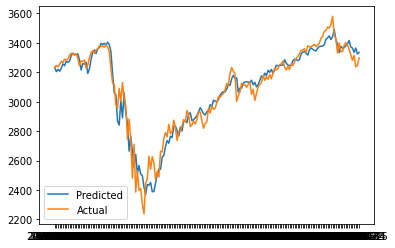

In [120]:
plt.plot(x, yPreds, label = 'Predicted')
plt.plot(x, yTrues, label = 'Actual')
plt.legend()
plt.savefig('graph.png')

In [119]:
import joblib
scaler_filename = "scalerCheat.save"
joblib.dump(scaler, scaler_filename)

['scalerCheat.save']

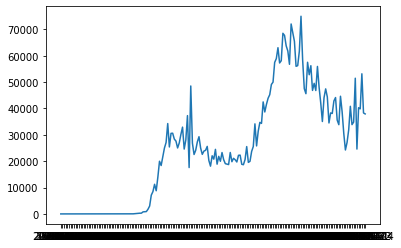

In [75]:
plt.plot(dataframe['casesDate'], dataframe['newCases'])

<AxesSubplot:>

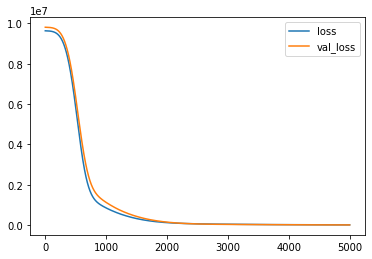

In [107]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()